# Web Mining - Assignment 2

Name and ID : Roi Pillar, 308292135

## Text pre-processing and exploration:

In [1]:
DATASET_FOLDER_PATH = './ohsumed'

Let's begin by importing all the neccessary libraries:

In [2]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import os
import re
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import string
import itertools
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
import bisect 
#-----------------------------classifiers----------------------------------:
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier


In [3]:
#returns a 4-tuple of training set, training labels, test set, and test labels.
def readDataset():
    path_training = DATASET_FOLDER_PATH + '/training'
    path_test = DATASET_FOLDER_PATH + '/test'
    
    sub_folder_names = []
    
    
    #sub folder names:
    for i in range(1,24):
        name = 'C' #we will "build" the names:
        
        if i in range(10):
            name+='0'
        name+=str(i)
        sub_folder_names.append(name)
        
    x_train , x_test, y_train, y_test = [] , [] , [] , [] 
    
    #construct the training set (for readability's sake, we will clean the data seperately):
    category=1
    for folder_name in sub_folder_names:
        base_path = path_training+'/'+folder_name
        for filename in os.listdir(base_path):
            f=open(base_path+'/'+filename,'r')
            raw=f.read()
            f.close()
            x_train.append(raw)
            y_train.append(category)
        category+=1
        
        
    #construct the test set
    category=1
    for folder_name in sub_folder_names:
        base_path = path_test+'/'+folder_name
        for filename in os.listdir(base_path):
            f=open(base_path+'/'+filename,'r')
            raw=f.read()
            f.close()
            x_test.append(raw)
            y_test.append(category)
        category+=1
        
    return x_train, y_train , x_test , y_test

x_train, y_train, x_test , y_test = readDataset()

print('Example document content:\n ' + x_train[1][:200] + '...\n\nCategory: '+str(y_train[1]))
print('\n\nExample document 2 content:\n ' + x_test[-1][:200] + '...\n\nCategory: '+str(y_test[-1]))

print('\nNumber of training dataset samples: '+str(len(x_train)))
print('Number of test dataset samples: '+str(len(x_test)))

Example document content:
 Multiple intracranial mucoceles associated with phaeohyphomycosis of the paranasal sinuses.
 The purpose of this article is to alert clinicians to a new pathogenic fungus of the paranasal sinuses call...

Category: 1


Example document 2 content:
 Enhanced mobilization of intracellular Ca2+ induced by halothane in hepatocytes isolated from swine susceptible to malignant hyperthermia.
 Halothane, in a dose-dependent manner, induced the release o...

Category: 23

Number of training dataset samples: 10433
Number of test dataset samples: 12733


Now let's get to cleaning (this method will be extended soon):

In [4]:
stop = set(stopwords.words('english'))
punctuation = set(string.punctuation) 
lemmatizer = WordNetLemmatizer()

#expects a list of documents, cleans and returns them
def cleanDataset(dataset):
    res = []
    for document in dataset:
        doc_lowered = document.lower()
        doc_lowered_split = doc_lowered.split()
        no_stop_words = ' '.join([word for word in doc_lowered_split if word not in stop])
        no_punctuation = ''.join([character for character in no_stop_words if character not in punctuation])
        lemmatized = [WordNetLemmatizer().lemmatize(word) for word in no_punctuation.split()]
#         numbers_to_n = numbers_to_N(lemmatized)
        clean_doc = ' '.join(lemmatized)
        res.append(clean_doc)
        
    return res


#lets clean the dataset:
x_train, x_test  = cleanDataset(x_train), cleanDataset(x_test)


x_train[0]

u'augmentation mentoplasty using mersilene mesh many different material available augmentation mentoplasty however optimal implant material chin implantation yet found past several year number experienced surgeon turned use mersilene mesh mersilene mesh nonabsorbable dacron polyester fiber conformed easily layer achieve tailored dimension shape mccollough plastic surgery clinic pa birmingham ala 277 patient 10year period underwent chin augmentation mersilene mesh implant material provides excellent tensile strength durability surgical adaptability overall complication rate 32 nine patient infection rate 25 seven patient removal secondary infection 17 five patient based 10year experience mersilene mesh remains material choice chin augmentation'

Note: our cleaning proccess rendered the text non-readable (by humans - it makes no sense in its now _clean_ form)

And now for some exploration:

-----------Training set statistics:-----------

Number of categories: 23





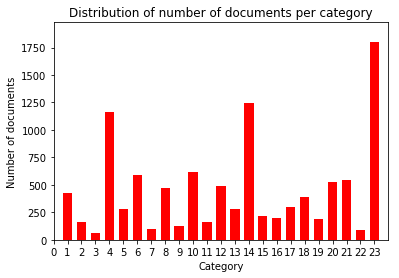

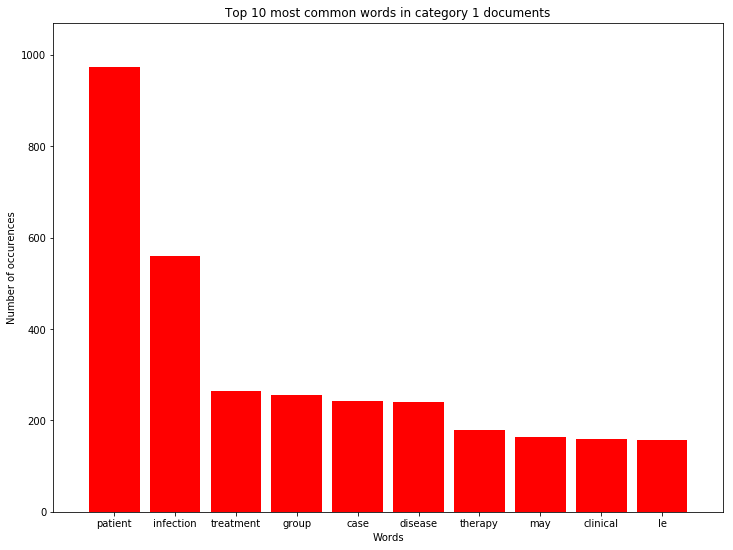

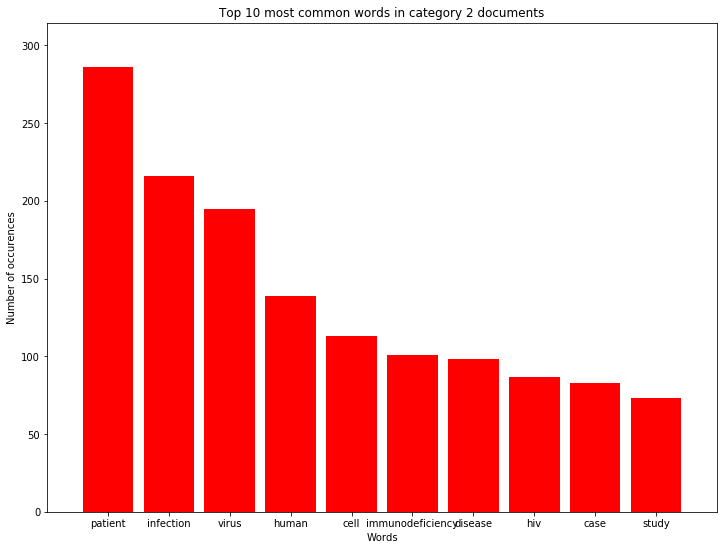

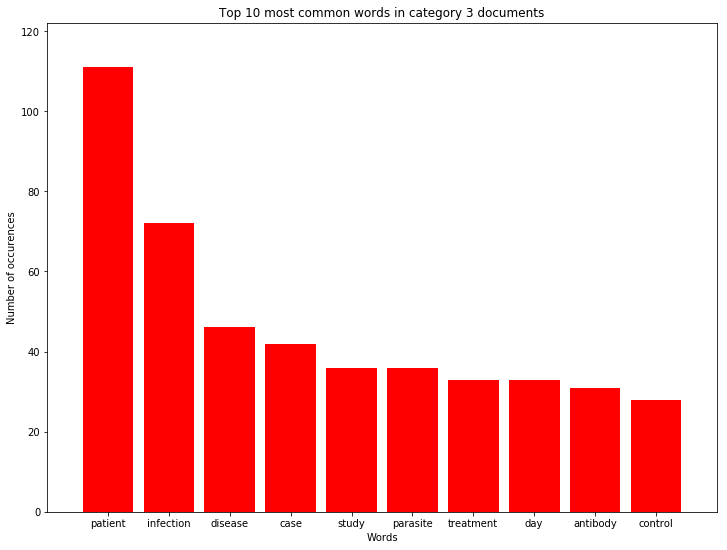

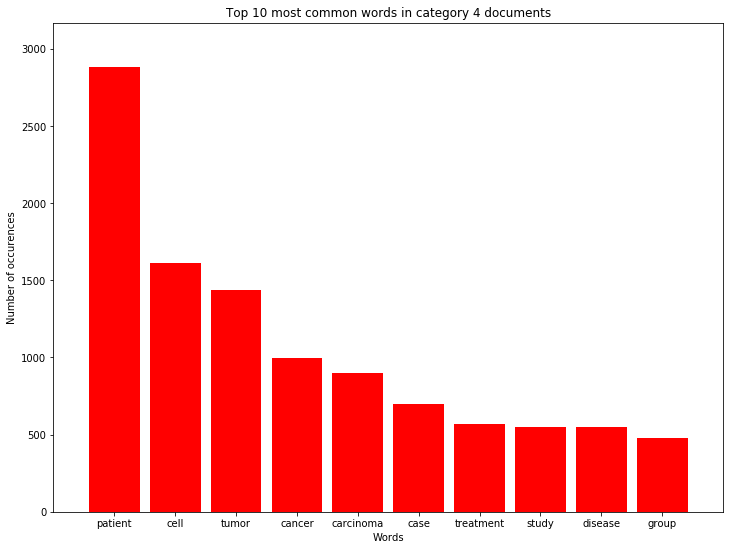

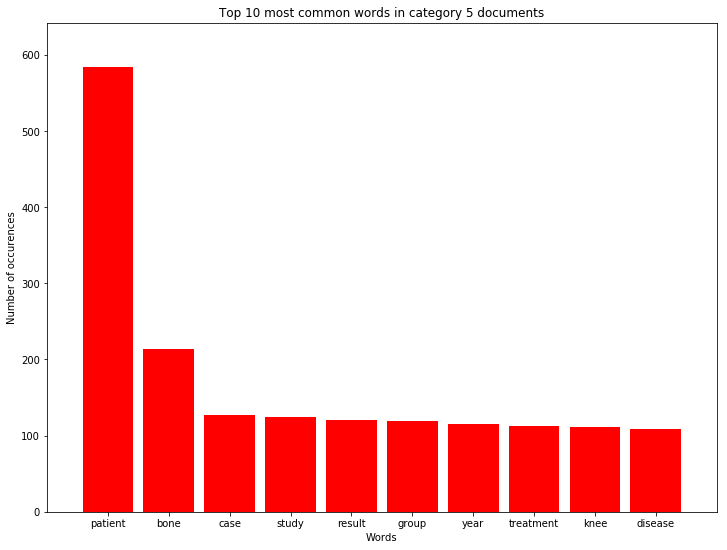

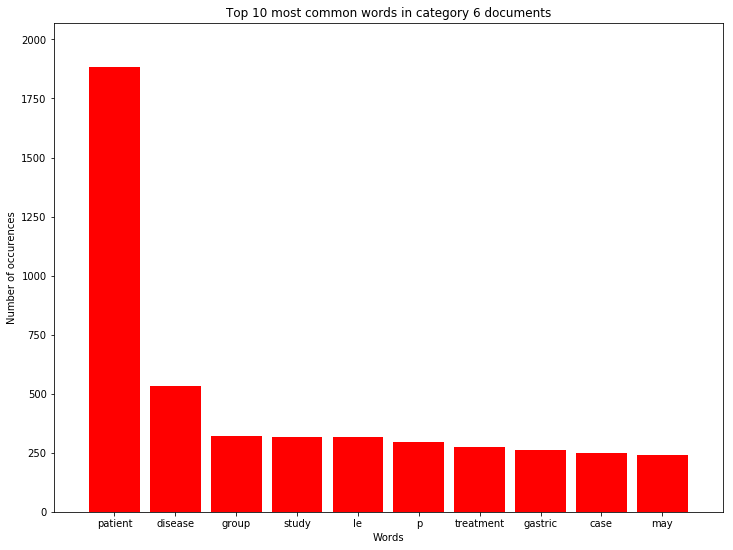

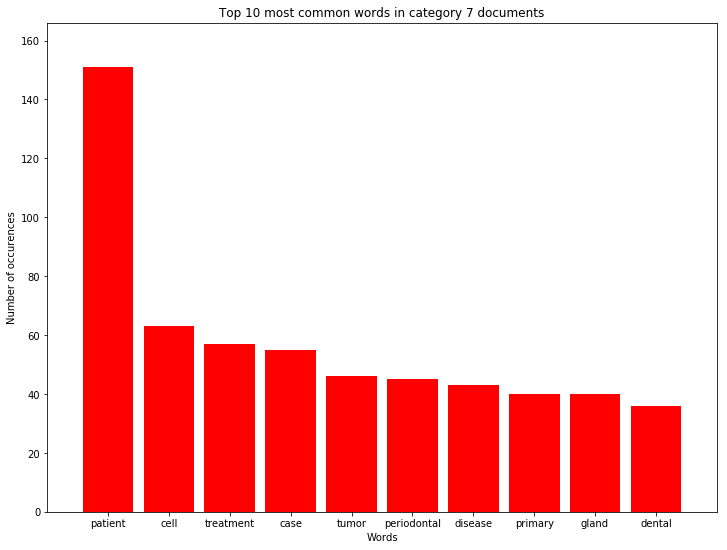

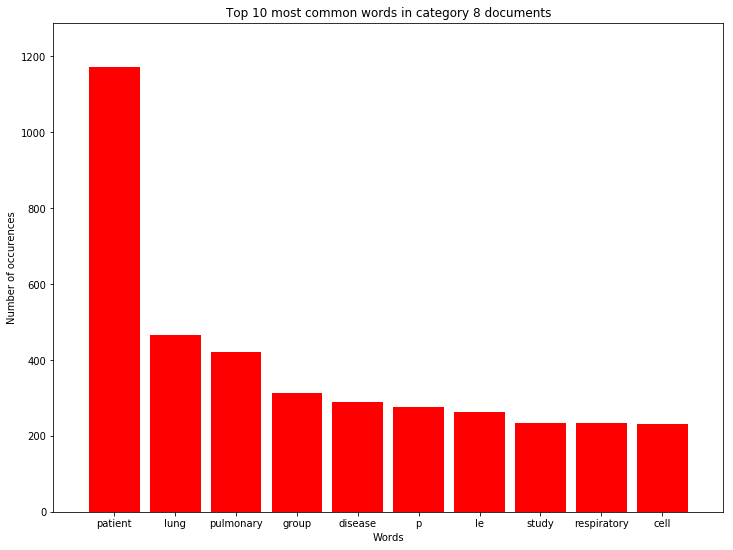

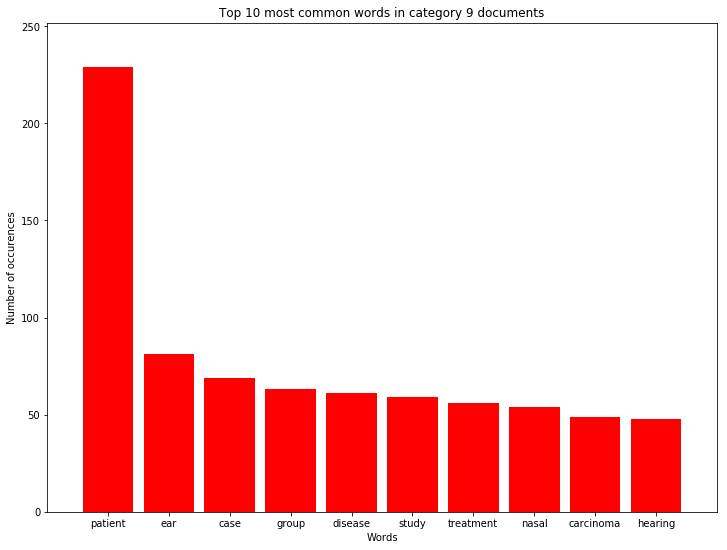

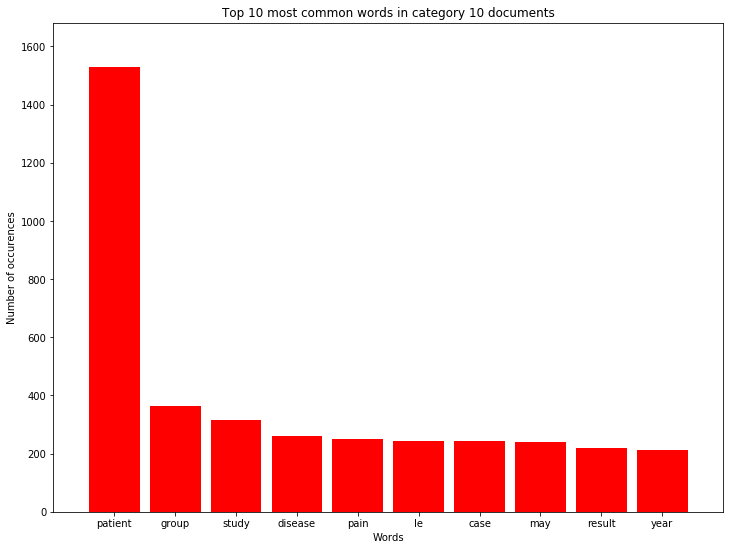

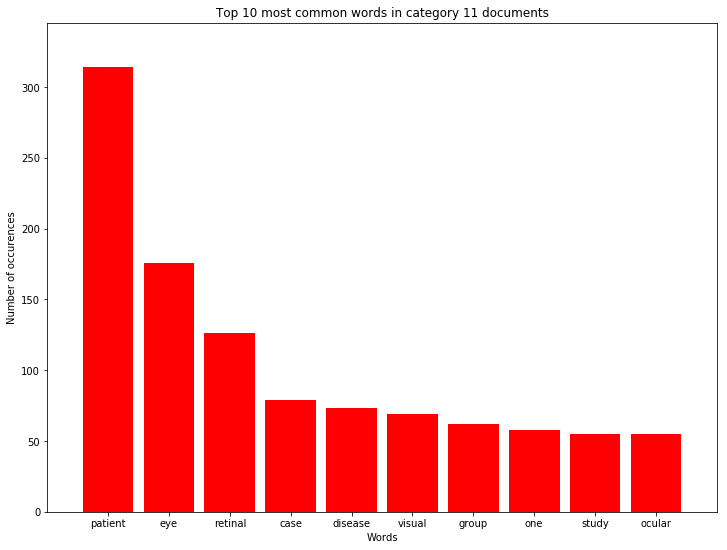

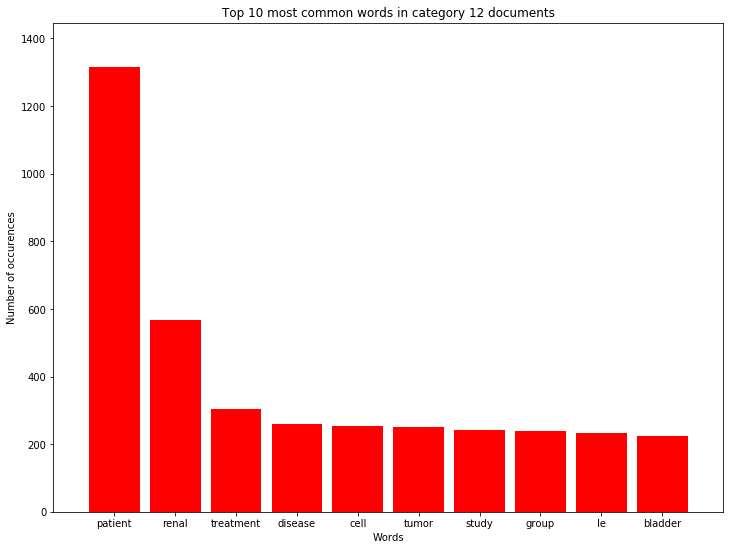

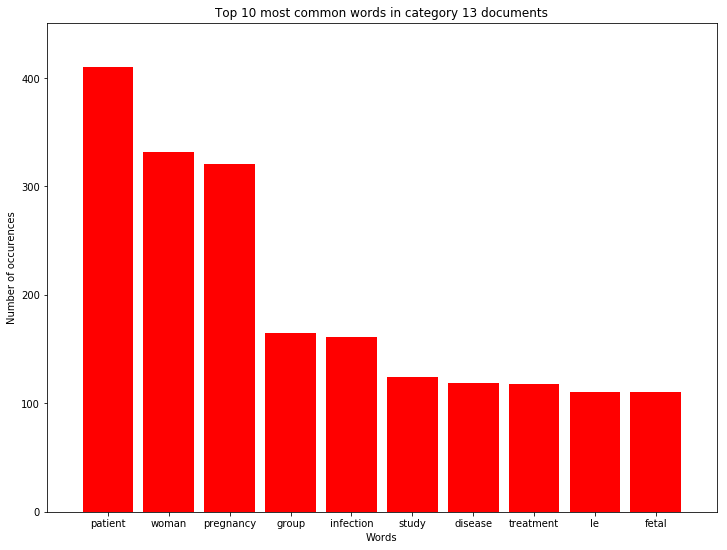

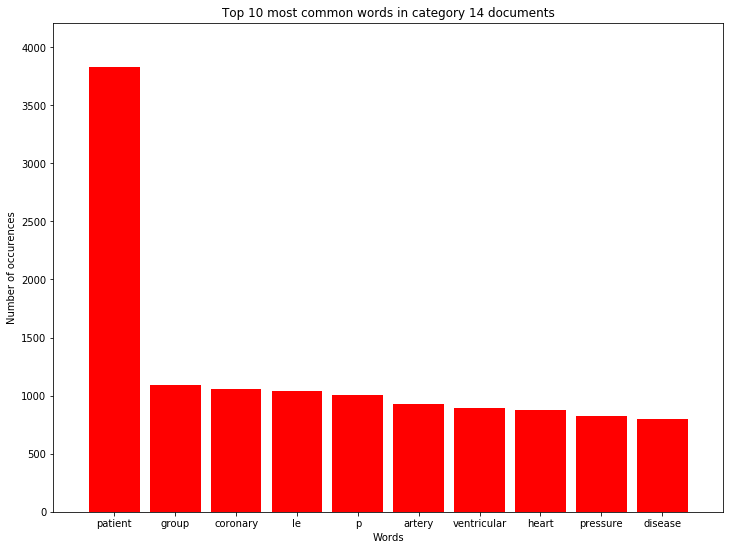

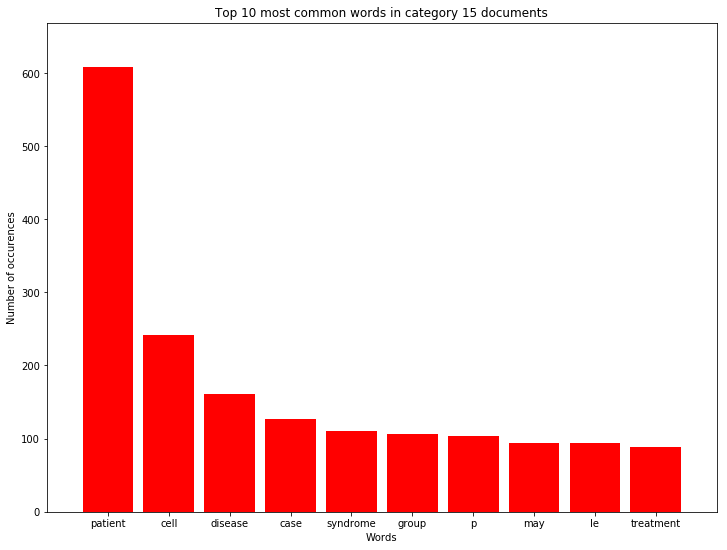

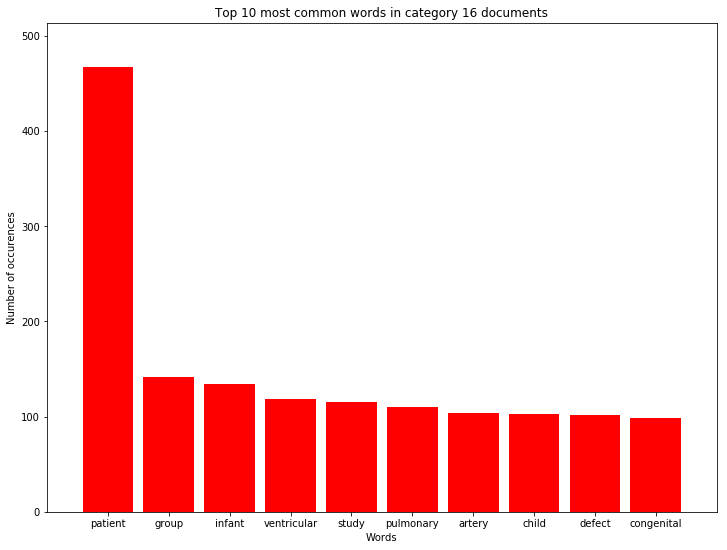

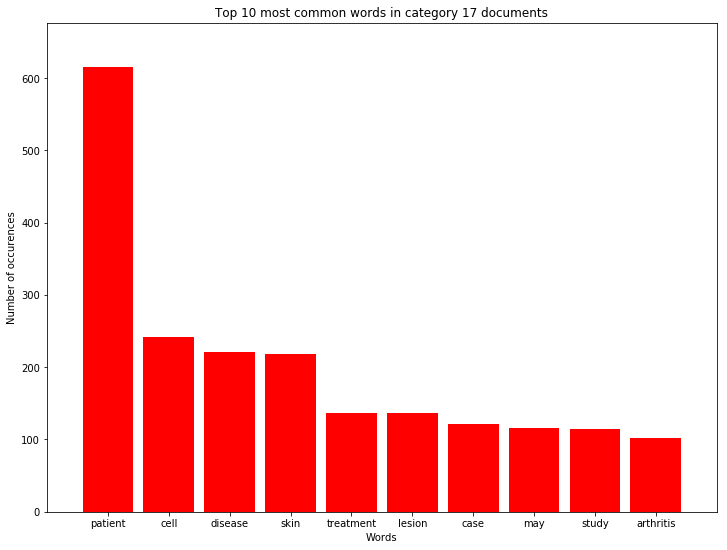

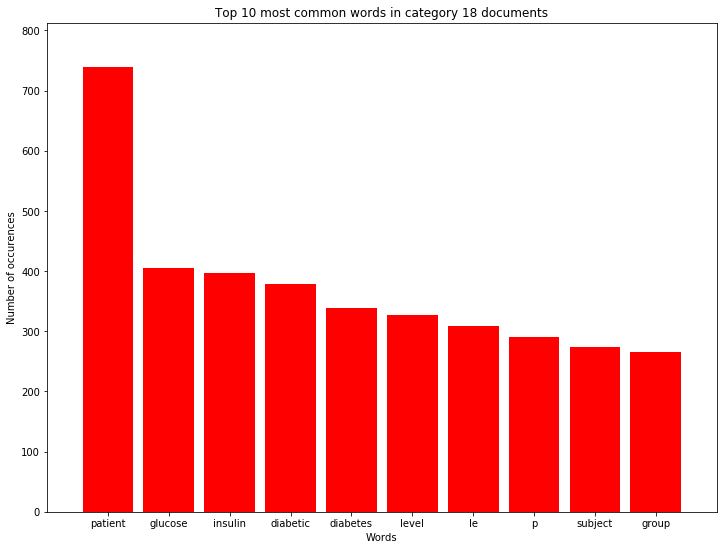

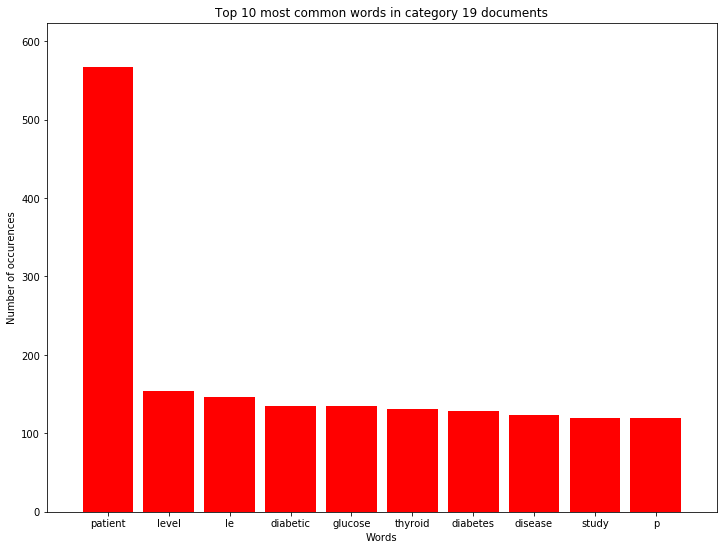

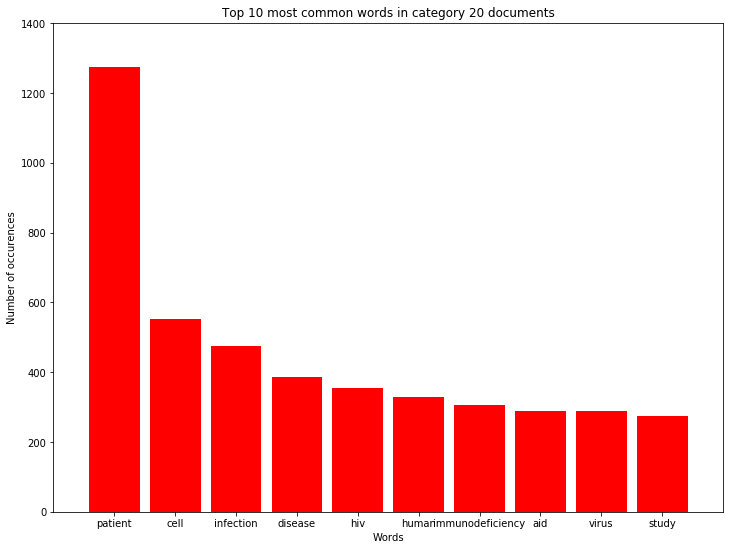

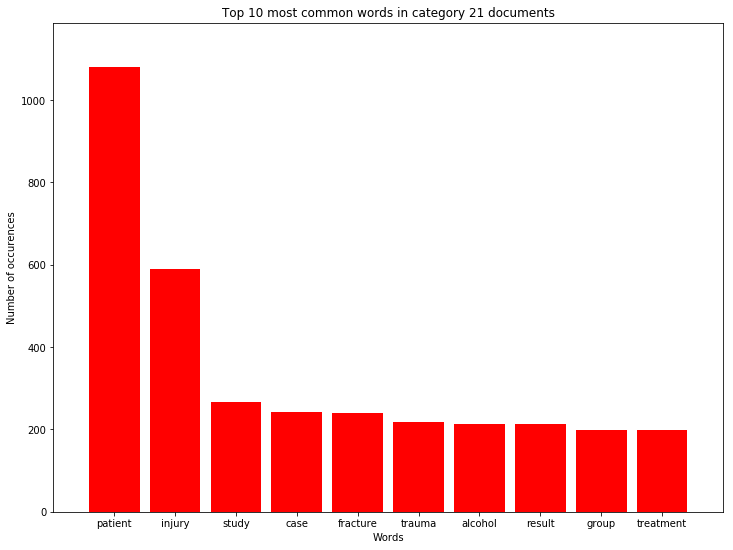

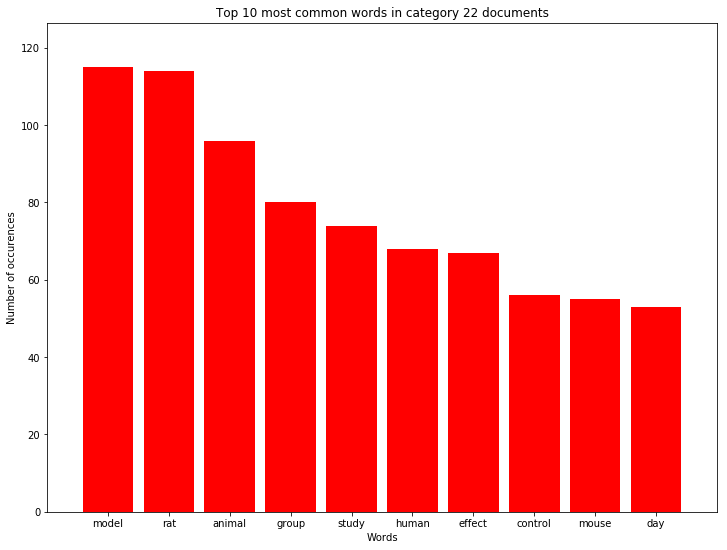

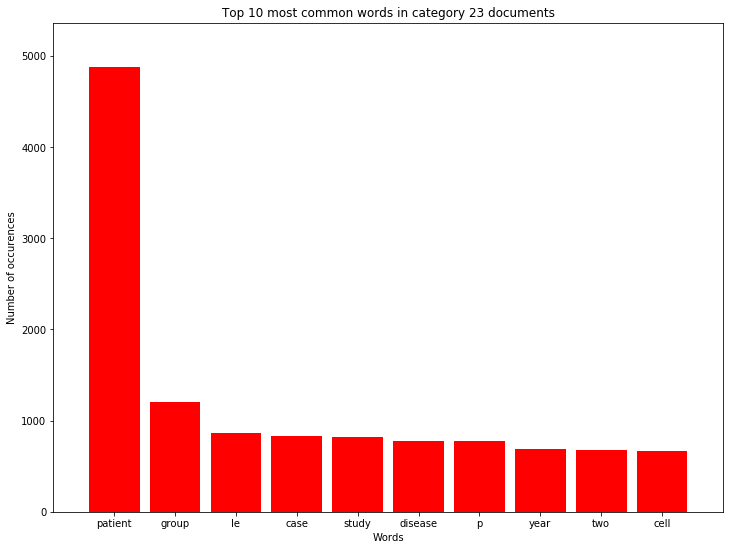

-----------Test set statistics:-----------

Number of categories: 23





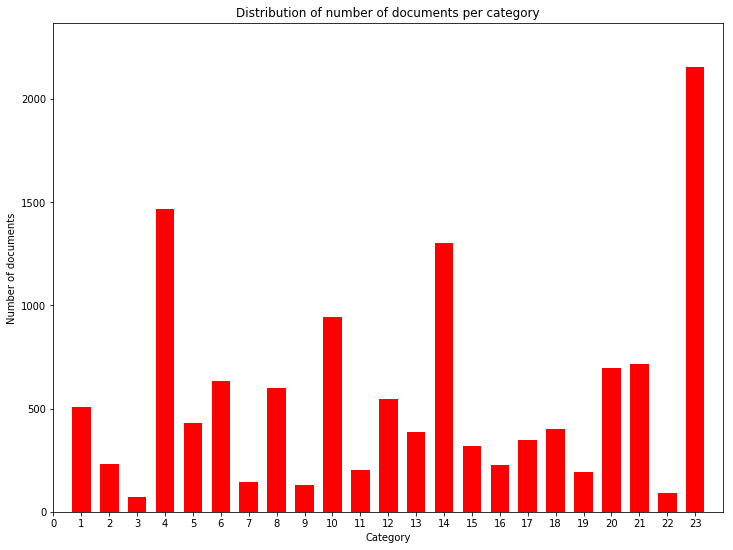

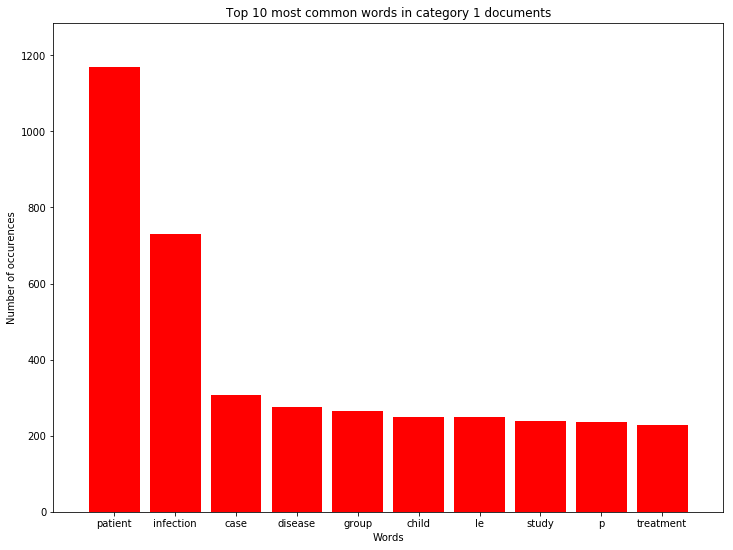

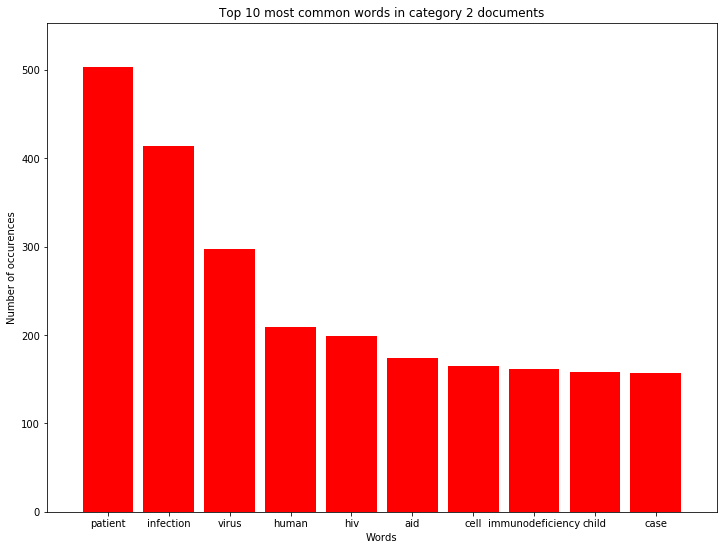

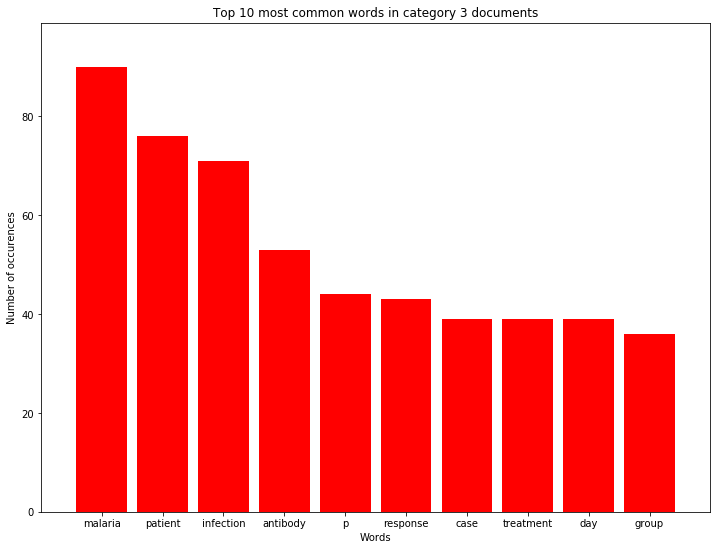

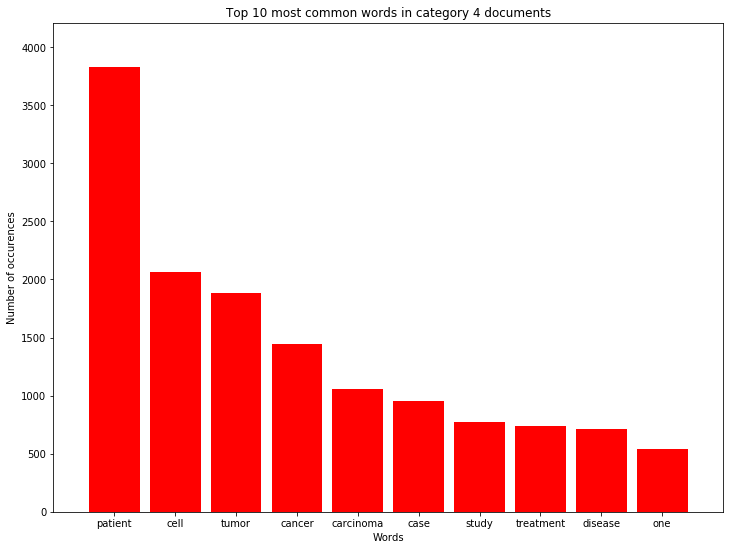

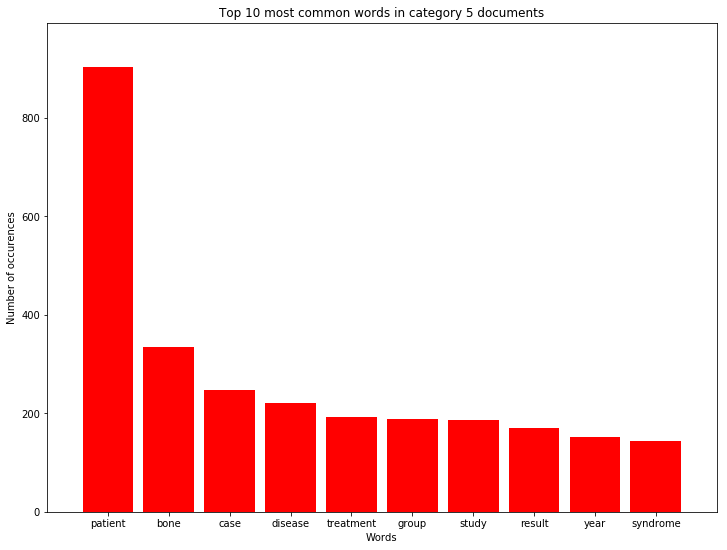

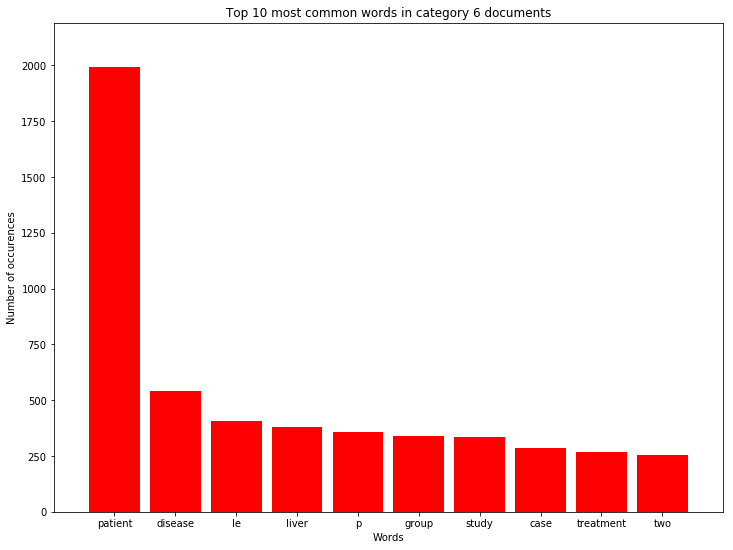

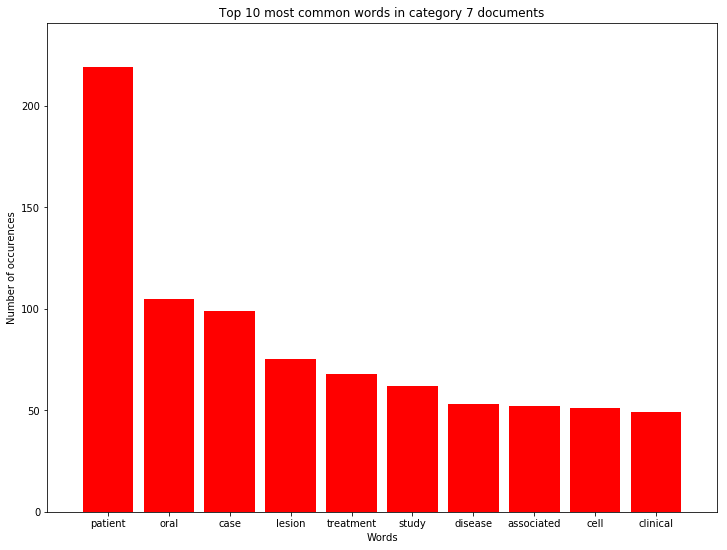

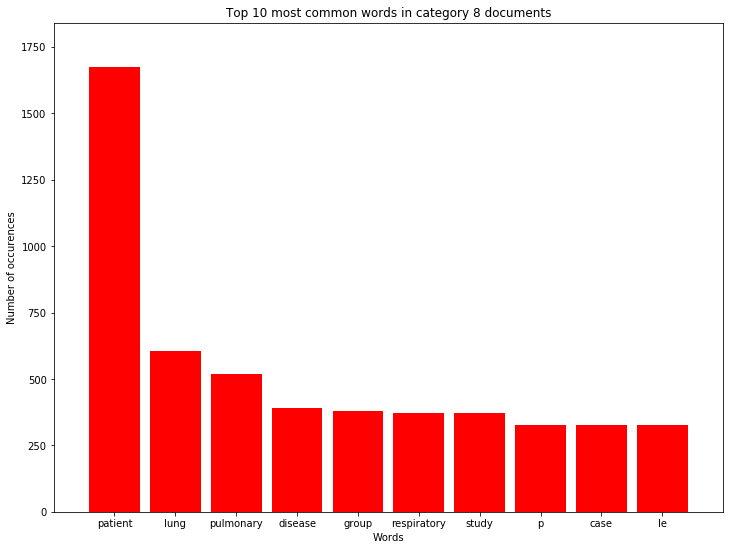

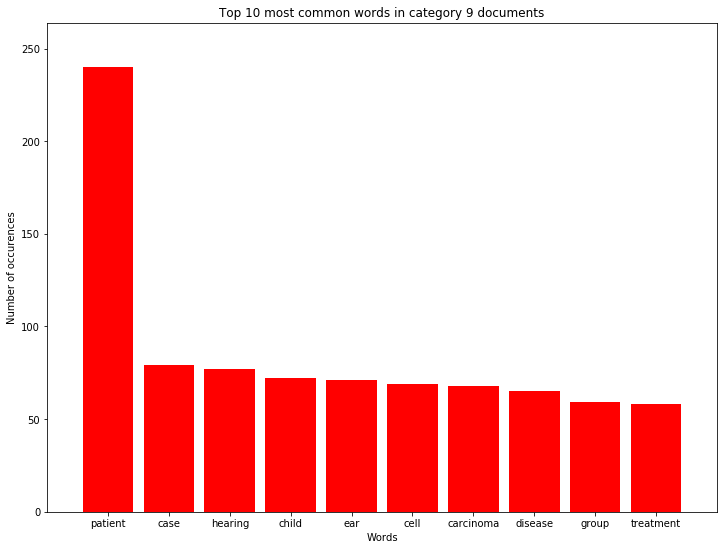

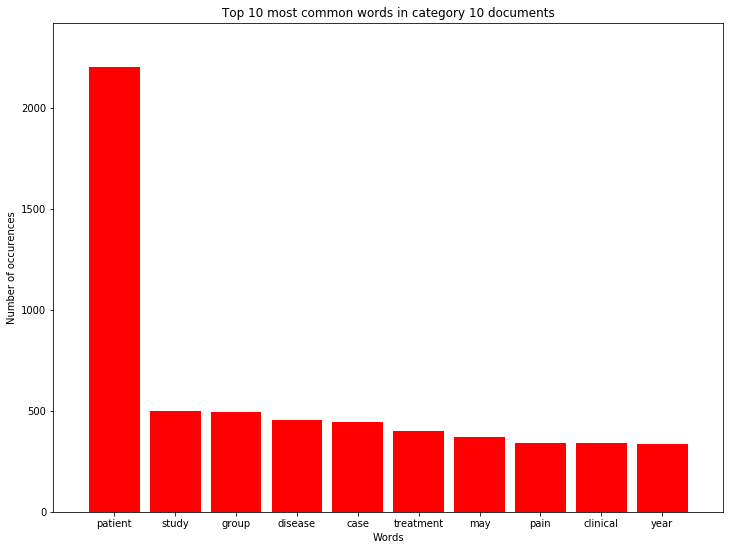

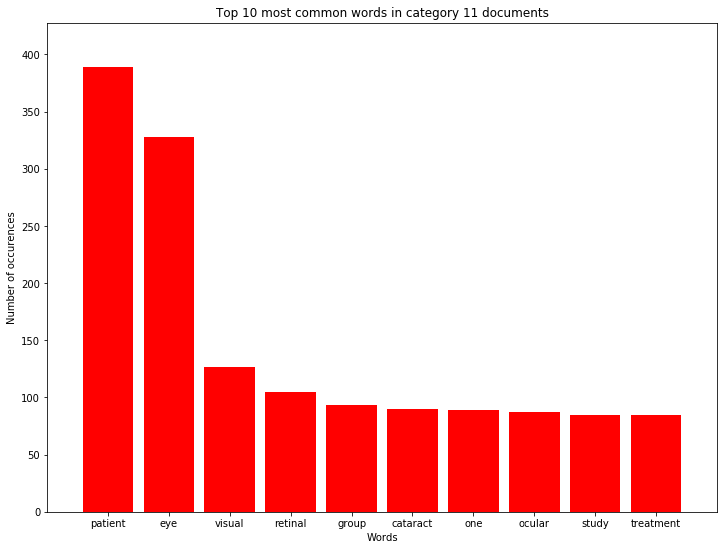

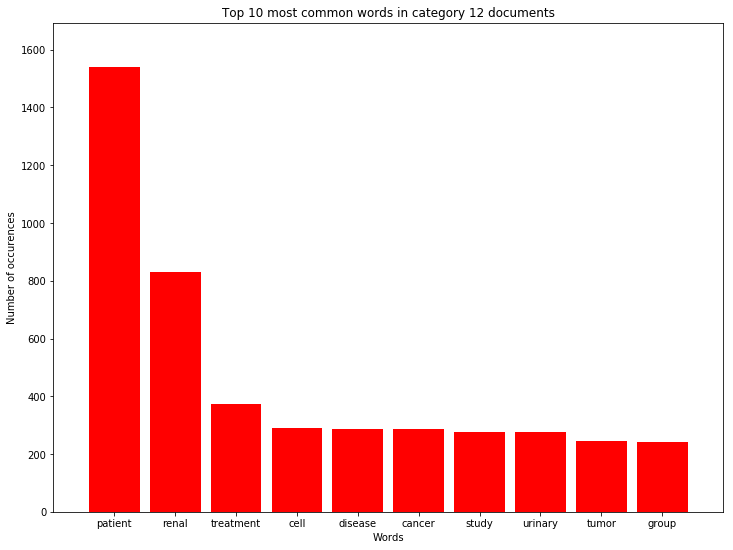

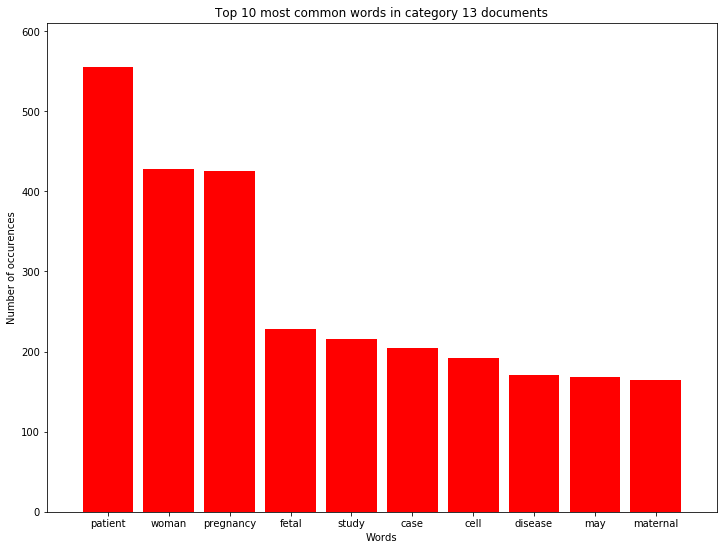

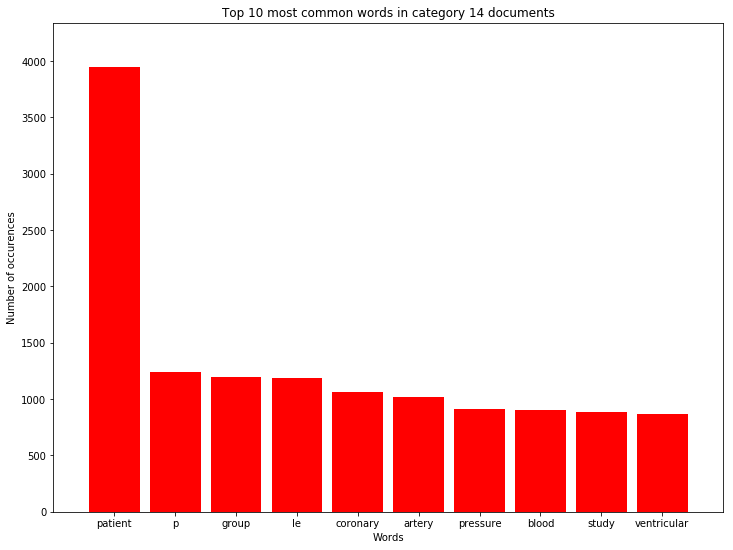

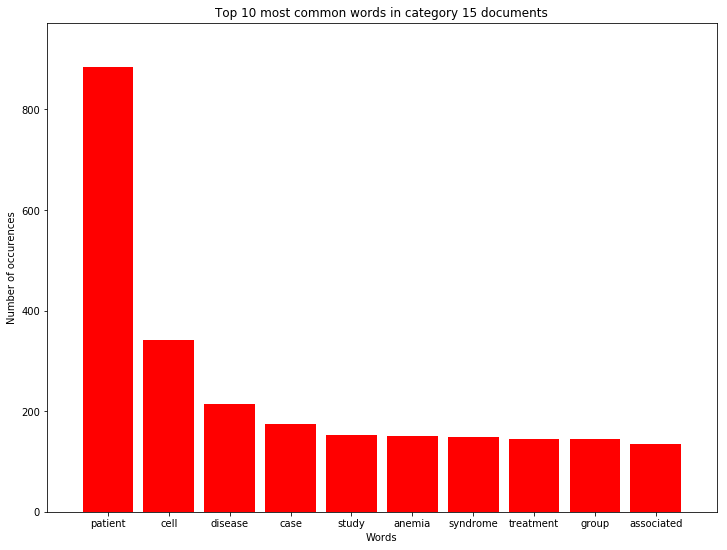

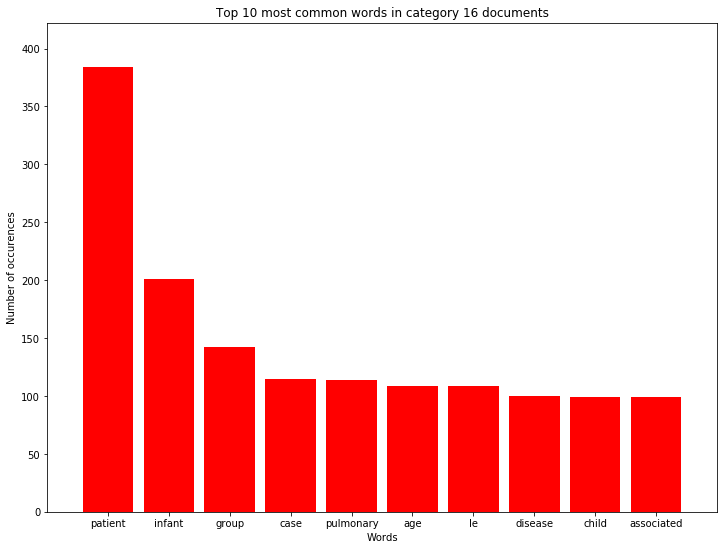

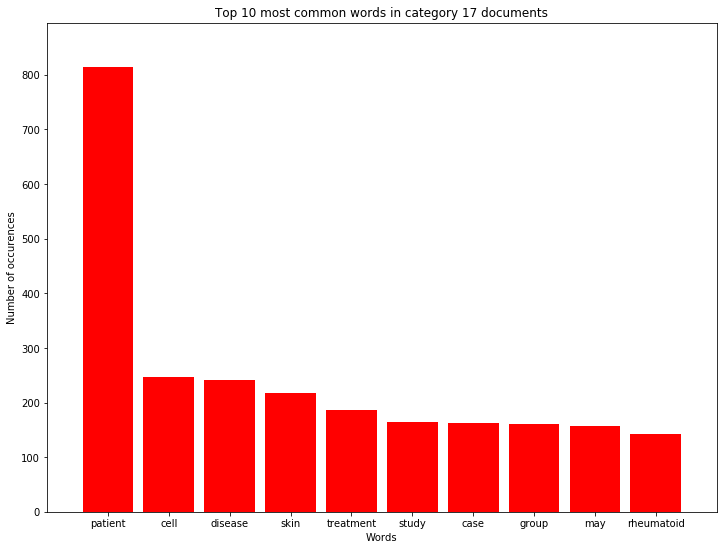

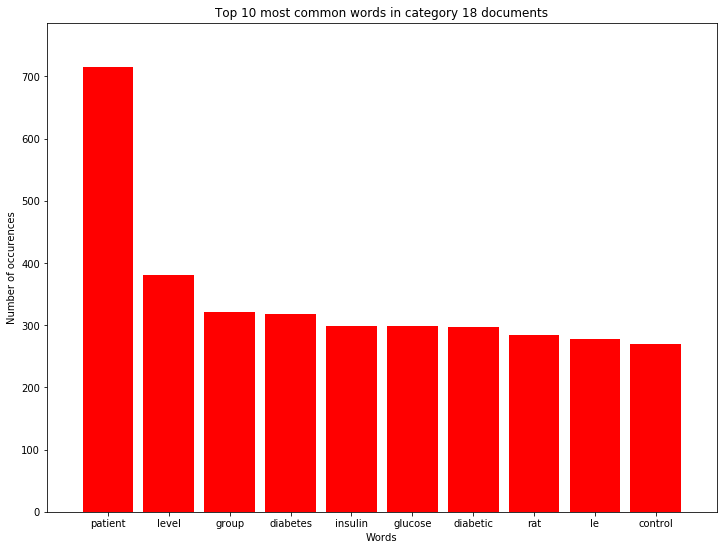

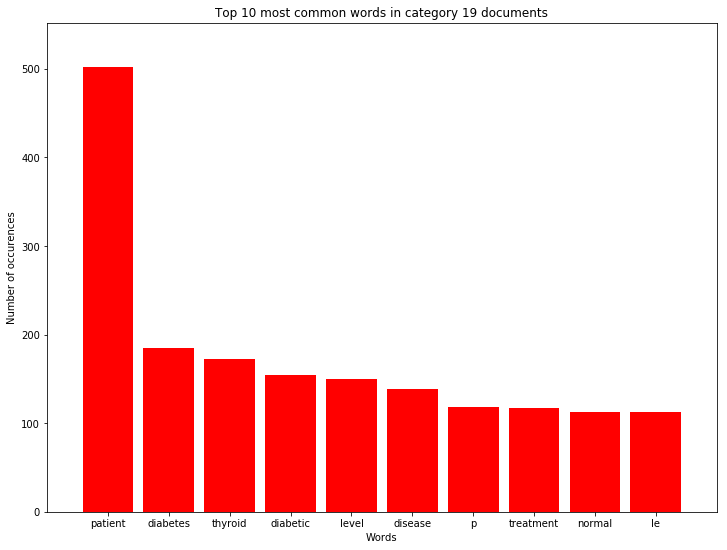

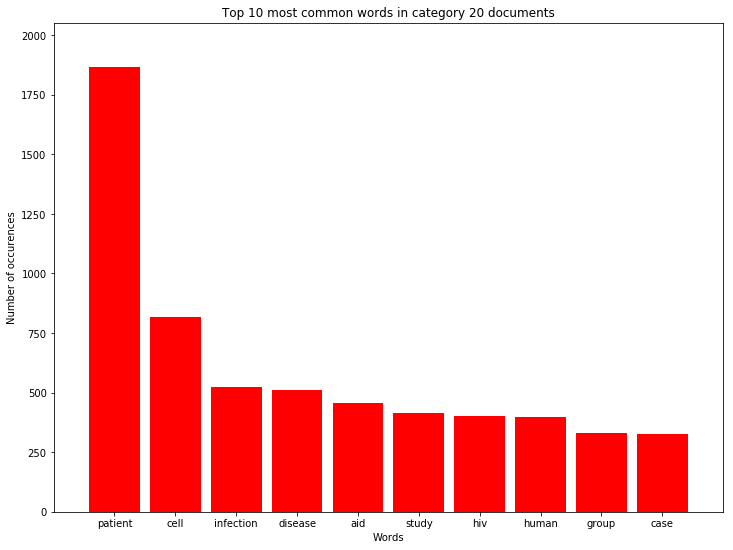

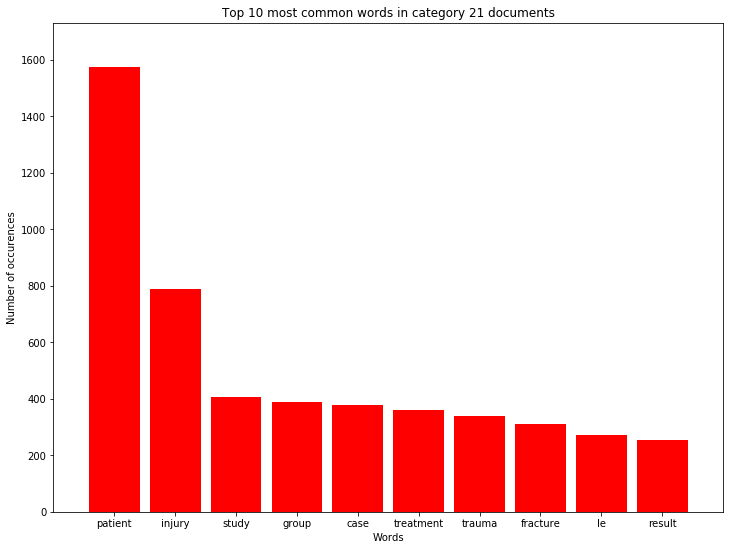

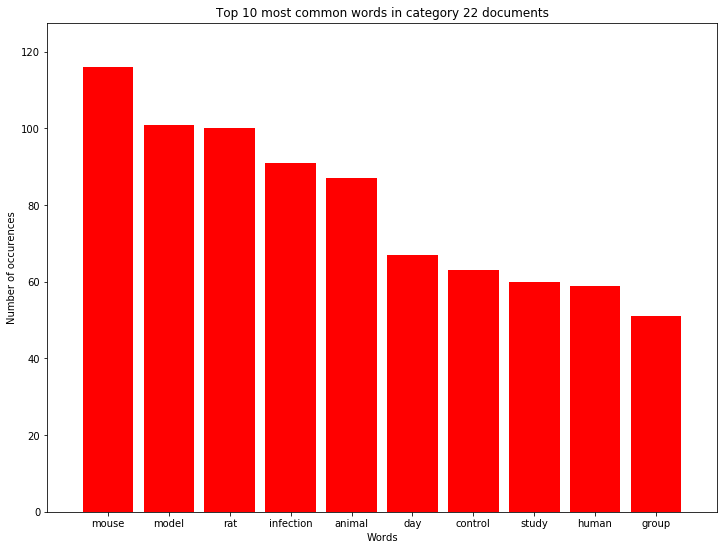

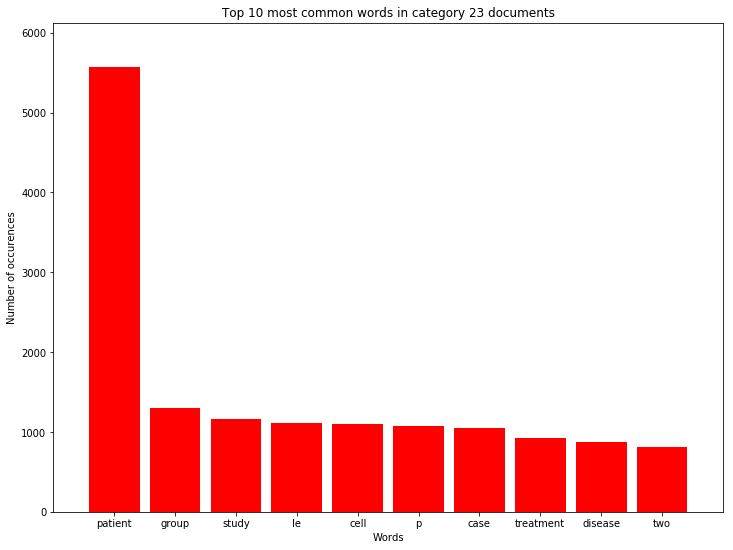

In [5]:
def exploreDataset(dataset_x, dataset_y):
    # number of categories:
    print('Number of categories: ' + str(dataset_y[-1]))
    print('\n\n')
    
    #number of documents per category:
    nums=[]
    num = 0
    
    for i in range(1,len(dataset_y)):
        if(dataset_y[i-1] != dataset_y[i]):
            nums.append(num+1)
            num=0
        else:    
            num+=1
            
    nums.append(num+1)        
            
            
    
    plt.title('Distribution of number of documents per category')
    plt.ylabel('Number of documents')
    plt.xlabel('Category')
    plt.axis([0, int(dataset_y[-1])+1, 0, 1.1*max(nums)])
    plt.xticks(range(0, dataset_y[-1]+1))
    width = 1/1.5
    plt.bar(range(1,dataset_y[-1]+1), nums, width, color="red")

    plt.show()
    
    
    #i will now concatenate all docs that share the same category, in order to gather statistics about term frequency
    #within each category. 
    x_seperated_by_categories = []
    current_category = 1
    #initiate doc list with first doc
    current_doc_concatenation = dataset_x[0]
    
    for i in range(1,len(dataset_y)):
        if(dataset_y[i-1] != dataset_y[i]):
            current_category+=1
            x_seperated_by_categories.append(current_doc_concatenation)
            #reset current document concatenation
            current_doc_concatenation = ''
            
        current_doc_concatenation+=' '+dataset_x[i]
        
    x_seperated_by_categories.append(current_doc_concatenation) 
    
    #now we have all documents of category x concatenated. let's check term frequency:
    
    current_category = 1
    for doc_concatenation in x_seperated_by_categories:
            counter = Counter(doc_concatenation.split())
            top_ten = counter.most_common(10)
            words, counts = zip(*top_ten)
            
            fig_size = plt.rcParams["figure.figsize"]
            fig_size[0] = 12
            fig_size[1] = 9
            plt.rcParams["figure.figsize"] = fig_size
            plt.title('Top 10 most common words in category '+str(current_category)+' documents')
            plt.ylabel('Number of occurences')
            plt.xlabel('Words')
            plt.axis([0, 11, 0, 1.1*max(counts)])
            plt.xticks(range(1,11),words)
            width = 1/1.2
            plt.bar(range(1,11), counts, width, color="red")
            plt.show()
            
            current_category+=1

print('-----------Training set statistics:-----------\n')    
exploreDataset(x_train, y_train)
print('-----------Test set statistics:-----------\n')    
exploreDataset(x_test,y_test)

#### Expected challenges:

1. Looks like there are a lot of words that are quite ubiquitous across all documents, so much so that i will try to remove them from all documents as an extra cleaning step, and see if the results are different, and how so.
    In addition, there are a lot of numbers in the documents, i will also try to remove them and see where that gets us. I expect these steps to produce better results.
    
2. Would the holy trinity of BOW, n-grams, and TDF-IF features be enough to produce good results? is there need for extra, domain-specific features?

3. What classifiers should be considered for this application?

4. The data is quite unbalanced as can be seen on the first figure above - there are categories with very few documents (C03, C7 ,C22 ..), and categories with "too much" documents (C23)

5. a lot of words are semantically tied to more than 1 category which would make the features extracted from those words not as informative as they could be.

## Document classification:

I will extract features for TF-IDF, unigrams, bigrams, and trigrams to start.


Let's begin with a quick sanity check and train a simple SVM model with BOW, n-grams(2,3) and TF-IDF features extracted on a raw dataset, then compute the score on the test set:

In [6]:
x_train, y_train, x_test , y_test = readDataset()


shuffled_train , shuffled_test = list(zip(x_train, y_train)) , list(zip(x_test, y_test))

random.shuffle(shuffled_train)
random.shuffle(shuffled_test)

x_train, y_train  = zip(*shuffled_train) 

x_test, y_test = zip(*shuffled_test)


t0 = time()
print("Extracting features for training set data...")
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english', ngram_range=(1,3))
v_x_train = vectorizer.fit_transform(x_train)

duration = time() - t0
print("Finished feature extraction in " + str(duration)[:5] + ' seconds')
samples , features = v_x_train.shape
print("Number of samples: " + str(samples))
print("Number of features: " + str(features))

print("Extracting features for test set data...")
t0 = time()
v_x_test = vectorizer.transform(x_test)
duration = time() - t0
print("Finished feature extraction in " + str(duration)[:5] + ' seconds')
samples , features = v_x_test.shape
print("Number of samples: " + str(samples))
print("Number of features: " + str(features))


Extracting features for training set data...
Finished feature extraction in 8.816 seconds
Number of samples: 10433
Number of features: 1076882
Extracting features for test set data...
Finished feature extraction in 4.776 seconds
Number of samples: 12733
Number of features: 1076882


In [7]:
clf = SGDClassifier()

t0 = time()
clf.fit(v_x_train, y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

t0 = time()
pred = clf.predict(v_x_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

accuracy = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % accuracy)

precision = metrics.precision_score(y_test, pred, average='weighted')
print("precision:   %0.3f" % precision)

recall = metrics.recall_score(y_test, pred, average='weighted')
print("recall:   %0.3f" % recall)

f_measure = metrics.f1_score(y_test, pred, average='weighted')
                            
print("f_measure:   %0.3f" % f_measure)



W:\Anaconda3\envs\py27\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


train time: 1.542s
test time:  0.167s
accuracy:   0.442
precision:   0.433
recall:   0.442
f_measure:   0.409


W:\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
W:\Anaconda3\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


__The results we got are pretty bad__. This is because the data is multi-labeled, i.e some documents in the dataset can be correctly classified into more than 1 category, more specifically an array of categories.


For demonstration, let's try the exact same thing on the 20newsgroups dataset:

In [8]:
data_train = fetch_20newsgroups(subset='train', categories=None,
                                shuffle=True, random_state=42)

data_test = fetch_20newsgroups(subset='test', categories=None,
                               shuffle=True, random_state=42)

target_names = data_train.target_names

y_train, y_test = data_train.target, data_test.target
x_train , x_test = data_train.data , data_test.data




t0 = time()
print("Extracting features for training set data...")
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
v_x_train = vectorizer.fit_transform(x_train)

duration = time() - t0
print("Finished feature extraction in " + str(duration)[:5] + ' seconds')
samples , features = v_x_train.shape
print("Number of samples: " + str(samples))
print("Number of features: " + str(features))

print("Extracting features for test set data...")
t0 = time()
v_x_test = vectorizer.transform(x_test)
duration = time() - t0
print("Finished feature extraction in " + str(duration)[:5] + ' seconds')
samples , features = v_x_test.shape
print("Number of samples: " + str(samples))
print("Number of features: " + str(features))


clf = SGDClassifier()

t0 = time()
clf.fit(v_x_train, y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

t0 = time()
pred = clf.predict(v_x_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

accuracy = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % accuracy)

precision = metrics.precision_score(y_test, pred, average='weighted')
print("precision:   %0.3f" % precision)

recall = metrics.recall_score(y_test, pred, average='weighted')
print("recall:   %0.3f" % recall)

f_measure = metrics.f1_score(y_test, pred, average='weighted')
                            
print("f_measure:   %0.3f" % f_measure)


Extracting features for training set data...
Finished feature extraction in 3.023 seconds
Number of samples: 11314
Number of features: 129791
Extracting features for test set data...
Finished feature extraction in 1.569 seconds
Number of samples: 7532
Number of features: 129791
train time: 0.373s
test time:  0.035s
accuracy:   0.860
precision:   0.861
recall:   0.860
f_measure:   0.858


Much better results. Let's offer a new implementation of readDataset(), call it readMultilabelDataset(), use the same model, and see if we could improve our results:

In [9]:
def readMultilabelDataset():
    path_training = DATASET_FOLDER_PATH + '/training'
    path_test = DATASET_FOLDER_PATH + '/test'
    
    sub_folder_names = []
    
    
    #sub folder names:
    for i in range(1,24):
        name = 'C' #we will "build" the names:
        
        if i in range(10):
            name+='0'
        name+=str(i)
        sub_folder_names.append(name)
        
    x_train , x_test, y_train, y_test = [] , [] , [] , [] 
    
    #construct the training set (labels first, then samples):
    labels_dict_training = dict()
    
    category=1
    for folder_name in sub_folder_names:
        base_path = path_training+'/'+folder_name
        for filename in os.listdir(base_path):
            if labels_dict_training.get(filename, None) is None:
                labels_dict_training[filename] = [category]
            else:
                labels_dict_training[filename].append(category)
        category+=1
    
    category=1
    for folder_name in sub_folder_names:
        base_path = path_training+'/'+folder_name
        for filename in os.listdir(base_path):
            f=open(base_path+'/'+filename,'r')
            raw=f.read()
            f.close()
            x_train.append(raw)
            y_train.append(labels_dict_training[filename])
        
        
    #construct the test set
    labels_dict_test = dict()
    
    category=1
    for folder_name in sub_folder_names:
        base_path = path_test+'/'+folder_name
        for filename in os.listdir(base_path):
            if labels_dict_test.get(filename, None) is None:
                labels_dict_test[filename] = [category]
            else:
                labels_dict_test[filename].append(category)
        category+=1
    
    category=1
    for folder_name in sub_folder_names:
        base_path = path_test+'/'+folder_name
        for filename in os.listdir(base_path):
            f=open(base_path+'/'+filename,'r')
            raw=f.read()
            f.close()
            x_test.append(raw)
            y_test.append(labels_dict_test[filename])
        
    return x_train, y_train , x_test , y_test

x_train, y_train, x_test , y_test = readMultilabelDataset()

print('Example document content:\n ' + x_train[1][:200] + '...\n\nCategory: '+str(y_train[1]))
print('\n\nExample document 2 content:\n ' + x_test[-1][:200] + '...\n\nCategory: '+str(y_test[-1]))

print('\nNumber of training dataset samples: '+str(len(x_train)))
print('Number of test dataset samples: '+str(len(x_test)))


Example document content:
 Multiple intracranial mucoceles associated with phaeohyphomycosis of the paranasal sinuses.
 The purpose of this article is to alert clinicians to a new pathogenic fungus of the paranasal sinuses call...

Category: [1, 4, 9, 10]


Example document 2 content:
 Enhanced mobilization of intracellular Ca2+ induced by halothane in hepatocytes isolated from swine susceptible to malignant hyperthermia.
 Halothane, in a dose-dependent manner, induced the release o...

Category: [23]

Number of training dataset samples: 10433
Number of test dataset samples: 12733


Great. Now let's re-evaluate our first (sanity) model:

In [10]:
x_train, y_train, x_test , y_test = readMultilabelDataset()

y_train = MultiLabelBinarizer().fit_transform(y_train)
y_test = MultiLabelBinarizer().fit_transform(y_test)

t0 = time()
print("Extracting features for training set data...")
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english',ngram_range=(1,3))
v_x_train = vectorizer.fit_transform(x_train)

duration = time() - t0
print("Finished feature extraction in " + str(duration)[:5] + ' seconds')
samples , features = v_x_train.shape
print("Number of samples: " + str(samples))
print("Number of features: " + str(features))

print("Extracting features for test set data...")
t0 = time()
v_x_test = vectorizer.transform(x_test)
duration = time() - t0
print("Finished feature extraction in " + str(duration)[:5] + ' seconds')
samples , features = v_x_test.shape
print("Number of samples: " + str(samples))
print("Number of features: " + str(features))


clf = OneVsRestClassifier(Perceptron())

t0 = time()
clf.fit(v_x_train, y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

t0 = time()
pred = clf.predict(v_x_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

accuracy = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % accuracy)

precision = metrics.precision_score(y_test, pred, average='weighted')
print("precision:   %0.3f" % precision)

recall = metrics.recall_score(y_test, pred, average='weighted')
print("recall:   %0.3f" % recall)

f_measure = metrics.f1_score(y_test, pred, average='weighted')
                            
print("f_measure:   %0.3f" % f_measure)

Extracting features for training set data...
Finished feature extraction in 8.864 seconds
Number of samples: 10433
Number of features: 1076882
Extracting features for test set data...
Finished feature extraction in 4.638 seconds
Number of samples: 12733
Number of features: 1076882


W:\Anaconda3\envs\py27\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


train time: 1.654s
test time:  0.151s
accuracy:   0.221
precision:   0.649
recall:   0.619
f_measure:   0.631


The results are definitely better.
Note: the accuracy metric is never going to be impressive, because (from sklearn documentation):
In multilabel classification, [metrics.accuracy_score(pred,y_true)] computes subset accuracy: the set of labels predicted for a sample must __exactly__ match the corresponding set of labels in y_true.
This is not a very forgiving definition of accuracy for the multi-label case, but nevertheless it is very informative, as it lets us know how much samples' predictions we got exactly right.

Now lets move on to __preprocessing:__

In [11]:
#gets list of tokens and turns all number tokens in it to N (an extra cleaning step, turned out to be less effective
#than removing the numbers alltogether.)
def numbers_to_N(tokens):
    res = []
    for token in tokens:
        if re.match('\d+$', token) or token in ['one','two','three','four','five','six','seven','eight','nine','ten']:
            res.append('N')
        else:
            res.append(token)
            
    return res      

#for example:
numbers_to_N(['221' ,'baker' ,'street']) 

['N', 'baker', 'street']

In [12]:
#removes all number tokens from a list of tokens
def remove_numbers(tokens):
    res = []
    for token in tokens:
        if re.match('\d+$', token) or token in ['one','two','three','four','five','six','seven','eight','nine','ten']:
            continue
        else:
            res.append(token)
            
    return res      

#for example:
remove_numbers(['221' ,'baker' ,'street']) 

['baker', 'street']

In [13]:
#removes some high frequency tokens from a list of tokens
def remove_domain_words(tokens):
    res = []
    for token in tokens:
        if token in ['patient', 'case', 'study', 'group', 'disease', 'treatment']:
            continue
        else:
            res.append(token)
            
    return res 

#for example:
remove_domain_words(['according' ,'to' ,'the', 'patient' ,'doctors','don\t','drink','on','the','job']) 

['according', 'to', 'the', 'doctors', 'don\t', 'drink', 'on', 'the', 'job']

Now after we have created some more cleaning tasks, we can extend our __cleanDataset()__ method to accept a specification of how the cleaning will be done using boolean parameters:

In [14]:
#expects a list of documents, cleans and returns them
def cleanDatasetExtended(dataset, is_remove_numbers=False, is_lemmatization=False, is_remove_domain_words=False , is_remove_punctuation=False, is_stemming=False):
    res = []
    #is_dirty = are all parameters false
    is_dirty = not is_remove_numbers and not is_lemmatization and not is_remove_domain_words and not is_remove_punctuation and not is_stemming

    for document in dataset:
        doc = document.lower()
        if is_remove_punctuation:
            doc = ''.join([character for character in doc if character not in punctuation])
    
        #remove stop words (this is relatively meaningless because the tdfifvectorizer already does this for us, but just to be safe)    
        #if all parameters of the function are false, no stop words removal either.
        if not is_dirty:
            doc = [word for word in doc.split() if word not in stop]
        
        
        if is_lemmatization:
            wl = WordNetLemmatizer()
            doc = [wl.lemmatize(word) for word in doc]
        
        if is_stemming:
            ps = PorterStemmer()
            doc = [ps.stem(word) for word in doc]  
                
        if is_remove_domain_words:
            doc = remove_domain_words(doc) 
        
        if is_remove_numbers:
            doc = remove_numbers(doc)
            
        
        if not is_dirty:
            doc = ' '.join(doc)
                
        res.append(doc)
        
    return res

x_train , _ , _ , _ = readMultilabelDataset()

x_clean = cleanDatasetExtended(x_train,is_remove_numbers=True, is_remove_punctuation=True, is_lemmatization=True, is_stemming=True,is_remove_domain_words=True) 
x_dirty = cleanDatasetExtended(x_train,is_remove_numbers=False, is_remove_punctuation=False, is_lemmatization=False, is_stemming=False,is_remove_domain_words=False) 

#for example:
print(x_dirty[0])
print(x_clean[0])

augmentation mentoplasty using mersilene mesh.
 many different materials are available for augmentation mentoplasty.
 however, the optimal implant material for chin implantation has yet to be found.
 during the past several years, a number of experienced surgeons have turned to the use of mersilene mesh.
 mersilene mesh is a non-absorbable dacron polyester fiber that can be conformed easily into layers to achieve tailored dimensions and shape.
 at the mccollough plastic surgery clinic pa, birmingham, ala, 277 patients over a 10-year period underwent chin augmentation with mersilene mesh implants.
 the material provides excellent tensile strength, durability, and surgical adaptability.
 the overall complication rate was 3.2% (nine patients); infection rate, 2.5% (seven patients); and removal secondary to infection, 1.7% (five patients).
 based on this 10-year experience, mersilene mesh remains our material of choice for chin augmentation.

augment mentoplasti use mersilen mesh mani diff

Varying the paramaters means (amongst other things) changing the feature extraction process, so we will vary the ngrams portion of our vectorizer,
extracting any combination of 2,3,4 and 5-grams: (1-grams=BOW doesn't do so well alone).



 Note: vectorizers with the max_df setting at default (=1) performed much worse than the ones with
    a custom value for max_df. This can be attributed to the fact that there are plenty of common words between the documents
    (medical field words - patient, treatment, etc..) which do not help the training process at all, but rather hinder it.
    later on we will fine tune the max_df parameter.

Let's define our vectorizers:

In [15]:
vectorizers = (
    (TfidfVectorizer(sublinear_tf=True, max_df=0.5, ngram_range=(1,2)) ,'1-2 grams'),
    (TfidfVectorizer(sublinear_tf=True, max_df=0.5, ngram_range=(1,3)) ,'1-3 grams'),
    (TfidfVectorizer(sublinear_tf=True, max_df=0.5, ngram_range=(1,4)) ,'1-4 grams'),
    (TfidfVectorizer(sublinear_tf=True, max_df=0.5, ngram_range=(1,5)) ,'1-5 grams'),
)   


Now let's define the collection of classifiers we will use: (i commented out some of the classifiers that did not work well - meaning either they took to much time to train or they produced very low metrics, or they are unsuited for the multi-class multi-label task.

In [16]:
classifiers = (
   (KNeighborsClassifier(3) , 'K-Neighbors' , 'KN'),
    
#SVM classifiers took very long to execute and produced only average results for me - therefore i am leaving them out.
# (SVC(kernel="linear", C=0.025), 'Linear Kernel SVM' , 'LSVM'),
# (SVC(gamma=2, C=1), 'RBF Kernel SVM' , 'SVM'),
    
  #Gradient descent classifier:
  (SGDClassifier() , 'Gradient Descent' , 'SGD'),
    
        
  (DecisionTreeClassifier(max_depth=6), '6-deep Decision Tree', '6DT'),
  (DecisionTreeClassifier(max_depth=5), '5-deep Decision Tree', '5DT'),
  (DecisionTreeClassifier(max_depth=4), '4-deep Decision Tree', '4DT'),
  (DecisionTreeClassifier(max_depth=3), '3-deep Decision Tree', '3DT'),

  #the random forest ensemble classifier does not compete with the other classifiers, however it trains quite quickly.
  (RandomForestClassifier(), 'Random Forest', 'RF'),

  (PassiveAggressiveClassifier(), 'Passive Aggressive', 'PA'),

  #perceptron (2 layers)
  (Perceptron(), 'Perceptron' , 'PRCP'),  
    

  #Multi layer perceptron classifier - the perceptron performed great on this dataset, so i would expect the MLP classifier
  #to perform well and even better, however in order to get it to run in a sane amount of time i had to reduce the number of
  #features to a number that caused the MLP not to perform well and under-generalize.
#    (MLPClassifier(), 'Multi Layer Perceptron' , 'MLP'),

  
  #adaptive boosting classifier (Yoav Freund) 
  (AdaBoostClassifier(), 'Adaptive Boosting' , 'AB'),
    
  #naive bayes  
  (MultinomialNB(), 'NB w/ Multinomial' , 'MNB')
    
 

)


Once we see which of the classifiers above (not including the ones commented out) are the most promising, we can further tune the model's parameters (e.g. - alpha for MLP and perceptron, gamma for SVM.)

Let's vary the cleaning process to see what produces the best results:

In [17]:
#varyCleaningProcess returns a list tuples, which each contain a clean training set, a clean test set, and a tag to indicate how the cleaning was done.
#the tag is a permutation over all possible parameter assignments that comprise that particular cleaning process,
#(example for a tag - is_remove_numbers=True, is_lemmatization=False,is_remove_domain_words=True, 
#is_punctuation=False, is_stemming=False)
def varyCleaningProcess(training, test):
    #this produces a list of tuples which are all the possible arrangements of True,False among the cleaning steps we will use
    parameter_possibilities = list(itertools.product([0, 1], repeat=5))
    
    remove_numbers_possibility_index = 0
    lemmatization_possibility_index = 1
    remove_domain_words_possibility_index = 2
    remove_punctuation_possibility_index = 3
    stemming_possibility_index = 4

    #this will be a list of tuples.
    res = []
    
    for possibility in parameter_possibilities:
        
        is_remove_numbers = bool(possibility[remove_numbers_possibility_index])
        is_lemmatization = bool(possibility[lemmatization_possibility_index])
        is_remove_domain_words = bool(possibility[remove_domain_words_possibility_index])
        is_remove_punctuation = bool(possibility[remove_punctuation_possibility_index])
        is_stemming = bool(possibility[stemming_possibility_index])
        
        
        current_training  = cleanDatasetExtended(training, is_remove_numbers, is_lemmatization, is_remove_domain_words, is_remove_punctuation, is_stemming)  
        current_test = cleanDatasetExtended(test, is_remove_numbers, is_lemmatization,is_remove_domain_words, is_remove_punctuation, is_stemming)
        current_tag= '\nremove numbers : ' + str(is_remove_numbers)
        current_tag+= '\nlemmatization : ' + str(is_lemmatization)
        current_tag+= '\nremove domain words : '+str(is_remove_domain_words)
        current_tag+= '\nremove punctuation : '+str(is_remove_punctuation)
        current_tag+= '\nstemming : '+str(is_stemming)

        tagged_clean_dataset = (current_training , current_test , current_tag)
        
        res.append(tagged_clean_dataset)
    
    return res

In [18]:
#the following function computes the hamming score (label-based accuracy) given some predicted results and the true results (off of stackoverflow)
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

### The following function takes a very long while to run (1.5 days on my machine)
its results are attached as 'optimizePipeline.txt' 

In [19]:
def optimizePipeline(classifiers,vectorizers):
    t0 = time()

    x_train, y_train, x_test , y_test = readMultilabelDataset()

           
    y_train = MultiLabelBinarizer().fit_transform(y_train)
    y_test = MultiLabelBinarizer().fit_transform(y_test)
    
     #to be perfectly clear, each element of various_clean_datasets is a tuple of (training dataset ,test dataset, tag),
     #where dataset is a list of documents, and tag is a permutation over all possible cleaning process parameter values.
    various_clean_datasets = varyCleaningProcess(x_train,x_test)

    
    print('Cleaning & storing datasets completed in '+str(time()-t0)+' seconds')
    
    
    models = list(itertools.product(various_clean_datasets,vectorizers,classifiers))
    
    print('number of models ' +str(len(models)))
    #exact accuracy is subset accuracy, meaning the percent of samples that were predicted EXACTLY as they should have 
    exact_accuracies = []
    #hamming score (or jaccard index) is defined as the number of correctly predicted labels divided by 
    #the cardinality of the union of predicted and true labels
    hamming_scores = []
    precisions = []
    recalls = []
    f_measures = []
    
  
    i=0
    for (x_train, x_test, tag) , vectorizer_tuple , classifier_tuple in models:
        i+=1
        
        
        classifier , clf_name, clf_short_name = classifier_tuple
        vectorizer , vctr_name = vectorizer_tuple
    
        print('-'*8 + 'Started constructing model number '+str(i)+'-'*8)
        
        details = '\n\nModel specs:'+'\nClassifier: '+clf_name+'\nVectorizer: '+vctr_name+'\nCleaning parameters: '+tag

        
        #wrap the classifier in a binarizer to fit the multilabel task.
        classifier = OneVsRestClassifier(classifier)
        
        t0 = time()
        v_x_train = vectorizer.fit_transform(x_train)

        samples , features = v_x_train.shape
        details+="\nNumber of features: " + str(features)

        v_x_test = vectorizer.transform(x_test)
        details+="\nFeature extraction time: "+ str(time()-t0)+' seconds'

        t0 = time()
        classifier.fit(v_x_train, y_train)
        train_time = time() - t0
        details+="\nTraining time: %0.3fs" % train_time

        t0 = time()
        pred = classifier.predict(v_x_test)
        test_time = time() - t0
        details+="\nTest time:  %0.3fs" % test_time

        exact_accuracy = metrics.accuracy_score(y_test, pred)
        details+="\n\nSubset accuracy:   %0.3f" % exact_accuracy

        label_based_accuracy = hamming_score(y_test, pred)
        details+="\nLabel based score:   %0.3f" % label_based_accuracy
        
        details+='\nMicro-averaged metrics: '
        
        precision_micro = metrics.precision_score(y_test, pred, average='micro')
        details+="\nPrecision:   %0.3f" % precision_micro

        recall_micro = metrics.recall_score(y_test, pred, average='micro')
        details+="\nRecall:   %0.3f" % recall_micro

        f_measure_micro = metrics.f1_score(y_test, pred, average='micro')                              
        details+="\nF_measure:   %0.3f" % f_measure_micro
        
        details+='\nMacro-averaged metrics: '
        
        precision_macro = metrics.precision_score(y_test, pred, average='macro')
        details+="\nPrecision:   %0.3f" % precision_macro

        recall_macro = metrics.recall_score(y_test, pred, average='macro')
        details+="\nRecall:   %0.3f" % recall_macro

        f_measure_macro = metrics.f1_score(y_test, pred, average='macro')                              
        details+="\nF_measure:   %0.3f" % f_measure_macro

        details+='\nWeighted-average metrics: '
        
        precision_weighted = metrics.precision_score(y_test, pred, average='weighted')
        details+="\nPrecision:   %0.3f" % precision_weighted

        recall_weighted = metrics.recall_score(y_test, pred, average='weighted')
        details+="\nRecall:   %0.3f" % recall_weighted

        f_measure_weighted = metrics.f1_score(y_test, pred, average='weighted')                              
        details+="\nF_measure:   %0.3f" % f_measure_weighted
        
        
        exact_accuracies.append((exact_accuracy,details))
        hamming_scores.append((label_based_accuracy,details))  
        precisions.append((max(precision_micro,precision_macro,precision_weighted),details))    
        recalls.append((max(recall_micro,recall_macro,recall_weighted),details))
        f_measures.append((max(f_measure_micro,f_measure_macro,f_measure_weighted),details)) 



    return exact_accuracies , hamming_scores , precisions , recalls , f_measures    
        
exact_accuracies , hamming_scores , precisions , recalls , f_measures = optimizePipeline(classifiers,vectorizers)  




Cleaning & storing datasets completed in 1353.18899989 seconds
number of models 1408
--------Started constructing model number 1--------
--------Started constructing model number 2--------
--------Started constructing model number 3--------
--------Started constructing model number 4--------
--------Started constructing model number 5--------
--------Started constructing model number 6--------
--------Started constructing model number 7--------
--------Started constructing model number 8--------


W:\Anaconda3\envs\py27\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


--------Started constructing model number 9--------
--------Started constructing model number 10--------
--------Started constructing model number 11--------
--------Started constructing model number 12--------
--------Started constructing model number 13--------
--------Started constructing model number 14--------
--------Started constructing model number 15--------
--------Started constructing model number 16--------
--------Started constructing model number 17--------
--------Started constructing model number 18--------
--------Started constructing model number 19--------
--------Started constructing model number 20--------
--------Started constructing model number 21--------
--------Started constructing model number 22--------
--------Started constructing model number 23--------
--------Started constructing model number 24--------
--------Started constructing model number 25--------
--------Started constructing model number 26--------
--------Started constructing model number 27---

--------Started constructing model number 163--------
--------Started constructing model number 164--------
--------Started constructing model number 165--------
--------Started constructing model number 166--------
--------Started constructing model number 167--------
--------Started constructing model number 168--------
--------Started constructing model number 169--------
--------Started constructing model number 170--------
--------Started constructing model number 171--------
--------Started constructing model number 172--------
--------Started constructing model number 173--------
--------Started constructing model number 174--------
--------Started constructing model number 175--------
--------Started constructing model number 176--------
--------Started constructing model number 177--------
--------Started constructing model number 178--------
--------Started constructing model number 179--------
--------Started constructing model number 180--------
--------Started constructing

--------Started constructing model number 315--------
--------Started constructing model number 316--------
--------Started constructing model number 317--------
--------Started constructing model number 318--------
--------Started constructing model number 319--------
--------Started constructing model number 320--------
--------Started constructing model number 321--------
--------Started constructing model number 322--------
--------Started constructing model number 323--------
--------Started constructing model number 324--------
--------Started constructing model number 325--------
--------Started constructing model number 326--------
--------Started constructing model number 327--------
--------Started constructing model number 328--------
--------Started constructing model number 329--------
--------Started constructing model number 330--------
--------Started constructing model number 331--------
--------Started constructing model number 332--------
--------Started constructing

--------Started constructing model number 467--------
--------Started constructing model number 468--------
--------Started constructing model number 469--------
--------Started constructing model number 470--------
--------Started constructing model number 471--------
--------Started constructing model number 472--------
--------Started constructing model number 473--------
--------Started constructing model number 474--------
--------Started constructing model number 475--------
--------Started constructing model number 476--------
--------Started constructing model number 477--------
--------Started constructing model number 478--------
--------Started constructing model number 479--------
--------Started constructing model number 480--------
--------Started constructing model number 481--------
--------Started constructing model number 482--------
--------Started constructing model number 483--------
--------Started constructing model number 484--------
--------Started constructing

--------Started constructing model number 619--------
--------Started constructing model number 620--------
--------Started constructing model number 621--------
--------Started constructing model number 622--------
--------Started constructing model number 623--------
--------Started constructing model number 624--------
--------Started constructing model number 625--------
--------Started constructing model number 626--------
--------Started constructing model number 627--------
--------Started constructing model number 628--------
--------Started constructing model number 629--------
--------Started constructing model number 630--------
--------Started constructing model number 631--------
--------Started constructing model number 632--------
--------Started constructing model number 633--------
--------Started constructing model number 634--------
--------Started constructing model number 635--------
--------Started constructing model number 636--------
--------Started constructing

--------Started constructing model number 771--------
--------Started constructing model number 772--------
--------Started constructing model number 773--------
--------Started constructing model number 774--------
--------Started constructing model number 775--------
--------Started constructing model number 776--------
--------Started constructing model number 777--------
--------Started constructing model number 778--------
--------Started constructing model number 779--------
--------Started constructing model number 780--------
--------Started constructing model number 781--------
--------Started constructing model number 782--------
--------Started constructing model number 783--------
--------Started constructing model number 784--------
--------Started constructing model number 785--------
--------Started constructing model number 786--------
--------Started constructing model number 787--------
--------Started constructing model number 788--------
--------Started constructing

--------Started constructing model number 923--------
--------Started constructing model number 924--------
--------Started constructing model number 925--------
--------Started constructing model number 926--------
--------Started constructing model number 927--------
--------Started constructing model number 928--------
--------Started constructing model number 929--------
--------Started constructing model number 930--------
--------Started constructing model number 931--------
--------Started constructing model number 932--------
--------Started constructing model number 933--------
--------Started constructing model number 934--------
--------Started constructing model number 935--------
--------Started constructing model number 936--------
--------Started constructing model number 937--------
--------Started constructing model number 938--------
--------Started constructing model number 939--------
--------Started constructing model number 940--------
--------Started constructing

--------Started constructing model number 1074--------
--------Started constructing model number 1075--------
--------Started constructing model number 1076--------
--------Started constructing model number 1077--------
--------Started constructing model number 1078--------
--------Started constructing model number 1079--------
--------Started constructing model number 1080--------
--------Started constructing model number 1081--------
--------Started constructing model number 1082--------
--------Started constructing model number 1083--------
--------Started constructing model number 1084--------
--------Started constructing model number 1085--------
--------Started constructing model number 1086--------
--------Started constructing model number 1087--------
--------Started constructing model number 1088--------
--------Started constructing model number 1089--------
--------Started constructing model number 1090--------
--------Started constructing model number 1091--------
--------St

--------Started constructing model number 1223--------
--------Started constructing model number 1224--------
--------Started constructing model number 1225--------
--------Started constructing model number 1226--------
--------Started constructing model number 1227--------
--------Started constructing model number 1228--------
--------Started constructing model number 1229--------
--------Started constructing model number 1230--------
--------Started constructing model number 1231--------
--------Started constructing model number 1232--------
--------Started constructing model number 1233--------
--------Started constructing model number 1234--------
--------Started constructing model number 1235--------
--------Started constructing model number 1236--------
--------Started constructing model number 1237--------
--------Started constructing model number 1238--------
--------Started constructing model number 1239--------
--------Started constructing model number 1240--------
--------St

--------Started constructing model number 1372--------
--------Started constructing model number 1373--------
--------Started constructing model number 1374--------
--------Started constructing model number 1375--------
--------Started constructing model number 1376--------
--------Started constructing model number 1377--------
--------Started constructing model number 1378--------
--------Started constructing model number 1379--------
--------Started constructing model number 1380--------
--------Started constructing model number 1381--------
--------Started constructing model number 1382--------
--------Started constructing model number 1383--------
--------Started constructing model number 1384--------
--------Started constructing model number 1385--------
--------Started constructing model number 1386--------
--------Started constructing model number 1387--------
--------Started constructing model number 1388--------
--------Started constructing model number 1389--------
--------St

In [21]:
#sort by first element of tuples (ints) and get only top 10 in each category      

sorted_accuracies = sorted(exact_accuracies, key=lambda x: x[0])[-10:]
sorted_hamming_scores = sorted(hamming_scores, key=lambda x: x[0])[-10:]
sorted_precisions = sorted(precisions, key=lambda x: x[0])[-10:]
sorted_recalls = sorted(recalls, key=lambda x: x[0])[-10:]
sorted_f_measures = sorted(f_measures, key=lambda x: x[0])[-10:]

print('-'*8 + 'Top 10 subset accuracies: '+'-'*8)
for value,details in sorted_accuracies:
    print(details)

print('-'*8 + 'Top 10 label based accuracies: '+'-'*8)
for value,details in sorted_hamming_scores:
    print(details)    

print('-'*8 + 'Top 10 precisions: '+'-'*8)
for value,details in sorted_precisions:
    print(details)  

print('-'*8 + 'Top 10 recalls: '+'-'*8)
for value,details in sorted_recalls:
    print(details)   

print('-'*8 + 'Top 10 f-measures: '+'-'*8)
for value,details in sorted_f_measures:
    print(details) 

--------Top 10 subset accuracies: --------


Model specs:
Classifier: Perceptron
Vectorizer: 1-2 grams
Cleaning parameters: 
remove numbers : True
lemmatization : True
remove domain words : True
remove punctuation : False
stemming : True
Number of features: 458967
Feature extraction time: 7.11199998856 seconds
Training time: 0.791s
Test time:  0.132s

Subset accuracy:   0.257
Label based score:   0.521
Micro-averaged metrics: 
Precision:   0.728
Recall:   0.552
F_measure:   0.628
Macro-averaged metrics: 
Precision:   0.698
Recall:   0.515
F_measure:   0.588
Weighted-average metrics: 
Precision:   0.720
Recall:   0.552
F_measure:   0.621


Model specs:
Classifier: Perceptron
Vectorizer: 1-2 grams
Cleaning parameters: 
remove numbers : False
lemmatization : False
remove domain words : False
remove punctuation : True
stemming : True
Number of features: 448032
Feature extraction time: 6.68499994278 seconds
Training time: 0.808s
Test time:  0.132s

Subset accuracy:   0.258
Label based score

__A quick analysis of the results:__

1. The perceptron based models dominated in terms of f-measure (it has been that way for me throughout all tests)

2. 1-3 grams seem to be the best range for ngram features, independent of cleaning parameters.

3. Oddly enough, the best cleaning paramaters include ONLY stemming and removal of punctuation.

4. This is not the first time i had run this function, but it __is__ the largest computation i did (1408 models to train and evaluate), and that's why i chose to include it. I have reached some slightly better results, as can be seen below or in 'optimizePipeline2.txt'


Let's now optimize our best classifier's parameters (this is the perceptrons alpha parameter, and the amount of hidden layers). The dataset will __not__ be cleaned before the optimization (because with, and i have chosen the features that produce the best result (results are attached as gridsearch.png):

In [23]:
x_train, y_train, x_test , y_test = readMultilabelDataset()

Y_train = MultiLabelBinarizer().fit_transform(y_train)
Y_test = MultiLabelBinarizer().fit_transform(y_test)

x_clean_tr = cleanDatasetExtended(x_train,is_remove_numbers=True, is_remove_punctuation=True, is_lemmatization=True, is_stemming=True,is_remove_domain_words=True) 
x_clean_te = cleanDatasetExtended(x_test,is_remove_numbers=True, is_remove_punctuation=True, is_lemmatization=True, is_stemming=True,is_remove_domain_words=True) 

t0 = time()
print('------Grid search over perceptron parameters:------\n\n')
print("Extracting features for training set data...")
vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english', ngram_range=(1,3))
v_x_train = vectorizer.fit_transform(x_clean_tr)

duration = time() - t0
print("Finished feature extraction in " + str(duration)[:5] + ' seconds')
samples , features = v_x_train.shape
print("Number of samples: " + str(samples))
print("Number of features: " + str(features))

print("Extracting features for test set data...")
t0 = time()
v_x_test = vectorizer.transform(x_clean_te)
duration = time() - t0
print("Finished feature extraction in " + str(duration)[:5] + ' seconds')
samples , features = v_x_test.shape
print("Number of samples: " + str(samples))
print("Number of features: " + str(features))



parameters = {
    'estimator__alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
    "estimator__max_iter": list(range(1,40))
}

perceptron = OneVsRestClassifier(Perceptron())
gridsearch = GridSearchCV(perceptron, param_grid=parameters)

gridsearch.fit(v_x_train, Y_train)

print('done')
print "Best params: {}".format(gridsearch.best_params_)
print "Best f1 score: %.5f" % gridsearch.best_score_


------Grid search over perceptron parameters:------


Extracting features for training set data...
Finished feature extraction in 8.266 seconds
Number of samples: 10433
Number of features: 943093
Extracting features for test set data...
Finished feature extraction in 4.082 seconds
Number of samples: 12733
Number of features: 943093
done
Best params: {'estimator__alpha': 0.0001, 'estimator__max_iter': 11}
Best f1 score: 0.63961


Note that the above f1 score was calculated with cross validation on the training set only.

We will now optimize the max_df parameter of the vectorizer (max_df=x means only terms that have appeared in x or less of the documents will be extracted to features), because it seems to carry a lot of weight over the final results. We will do it once for a fully clean dataset, and another for a semi-clean one, more specifically the one that produced the best results in the experiments above.

results attached as optimize_max_df_full_clean.txt and optimize_max_df_semi_clean.txt:


In [30]:
def optimize_max_df(clean_training, clean_test, y_train, y_test):
    t0 = time()

           
    y_train = MultiLabelBinarizer().fit_transform(y_train)
    y_test = MultiLabelBinarizer().fit_transform(y_test)
    
        
    print('Cleaning & storing datasets completed in '+str(time()-t0)+' seconds')
    
    vctrzs = [(TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3),max_df=float(i)/100) ,'max_df = '+str(float(i)/100)) for i in range(1,101)]
    classifier = OneVsRestClassifier(Perceptron(alpha=0.0001,max_iter=8))
    models = vctrzs
    
    print('number of models ' +str(len(models)))
    exact_accuracies = []
    precisions = []
    recalls = []
    f_measures = []
    
  
    i=0
    for  vectorizer_tuple in models:
        i+=1
        vectorizer , vctr_name = vectorizer_tuple
    
        print('-'*8 + 'Started constructing model number '+str(i)+'-'*8)
        
        details = '\n\nModel specs:'+'\nVectorizer: '+vctr_name
        
        
        t0 = time()
        v_x_train = vectorizer.fit_transform(clean_training)

        samples , features = v_x_train.shape
        details+="\nNumber of features: " + str(features)

        v_x_test = vectorizer.transform(clean_test)
        details+="\nFeature extraction time: "+ str(time()-t0)+' seconds'

        t0 = time()
        classifier.fit(v_x_train, y_train)
        train_time = time() - t0
        details+="\nTraining time: %0.3fs" % train_time

        t0 = time()
        pred = classifier.predict(v_x_test)
        test_time = time() - t0
        details+="\nTest time:  %0.3fs" % test_time

        exact_accuracy = metrics.accuracy_score(y_test, pred)
        details+="\n\nSubset accuracy:   %0.3f" % exact_accuracy

        details+='\nMicro-averaged metrics: '
        
        precision_micro = metrics.precision_score(y_test, pred, average='micro')
        details+="\nPrecision:   %0.3f" % precision_micro

        recall_micro = metrics.recall_score(y_test, pred, average='micro')
        details+="\nRecall:   %0.3f" % recall_micro

        f_measure_micro = metrics.f1_score(y_test, pred, average='micro')                              
        details+="\nF_measure:   %0.3f" % f_measure_micro
        
        details+='\nMacro-averaged metrics: '
        
        precision_macro = metrics.precision_score(y_test, pred, average='macro')
        details+="\nPrecision:   %0.3f" % precision_macro

        recall_macro = metrics.recall_score(y_test, pred, average='macro')
        details+="\nRecall:   %0.3f" % recall_macro

        f_measure_macro = metrics.f1_score(y_test, pred, average='macro')                              
        details+="\nF_measure:   %0.3f" % f_measure_macro

        details+='\nWeighted-average metrics: '
        
        precision_weighted = metrics.precision_score(y_test, pred, average='weighted')
        details+="\nPrecision:   %0.3f" % precision_weighted

        recall_weighted = metrics.recall_score(y_test, pred, average='weighted')
        details+="\nRecall:   %0.3f" % recall_weighted

        f_measure_weighted = metrics.f1_score(y_test, pred, average='weighted')                              
        details+="\nF_measure:   %0.3f" % f_measure_weighted
        
        
        exact_accuracies.append((exact_accuracy,details))
        precisions.append((max(precision_micro,precision_macro,precision_weighted),details))    
        recalls.append((max(recall_micro,recall_macro,recall_weighted),details))
        f_measures.append((max(f_measure_micro,f_measure_macro,f_measure_weighted),details)) 

       
        


    return exact_accuracies , precisions , recalls , f_measures    
        

__results for optimized cleaning parameters:__

In [31]:
x_train, y_train, x_test , y_test = readMultilabelDataset()
clean_x_training = cleanDatasetExtended(x_train,is_stemming=True,is_remove_punctuation=True)
clean_x_test = cleanDatasetExtended(x_test,is_stemming=True,is_remove_punctuation=True)
exact_accuracies , precisions , recalls , f_measures = optimize_max_df(clean_x_training,clean_x_test,y_train,y_test)  

sorted_accuracies = sorted(exact_accuracies, key=lambda x: x[0])[-1:]
sorted_precisions = sorted(precisions, key=lambda x: x[0])[-1:]
sorted_recalls = sorted(recalls, key=lambda x: x[0])[-1:]
sorted_f_measures = sorted(f_measures, key=lambda x: x[0])[-1:]

print('-'*8 + 'best subset accuracy: '+'-'*8)
for value,details in sorted_accuracies:
    print(details)   

print('-'*8 + 'best precision: '+'-'*8)
for value,details in sorted_precisions:
    print(details)  

print('-'*8 + 'best recall: '+'-'*8)
for value,details in sorted_recalls:
    print(details)   

print('-'*8 + 'best f-measure: '+'-'*8)
for value,details in sorted_f_measures:
    print(details) 

Cleaning & storing datasets completed in 0.0569999217987 seconds
number of models 100
--------Started constructing model number 1--------
--------Started constructing model number 2--------
--------Started constructing model number 3--------
--------Started constructing model number 4--------
--------Started constructing model number 5--------
--------Started constructing model number 6--------
--------Started constructing model number 7--------
--------Started constructing model number 8--------
--------Started constructing model number 9--------
--------Started constructing model number 10--------
--------Started constructing model number 11--------
--------Started constructing model number 12--------
--------Started constructing model number 13--------
--------Started constructing model number 14--------
--------Started constructing model number 15--------
--------Started constructing model number 16--------
--------Started constructing model number 17--------
--------Started constr

Lets examine the impact of max_df's value on the model's results:

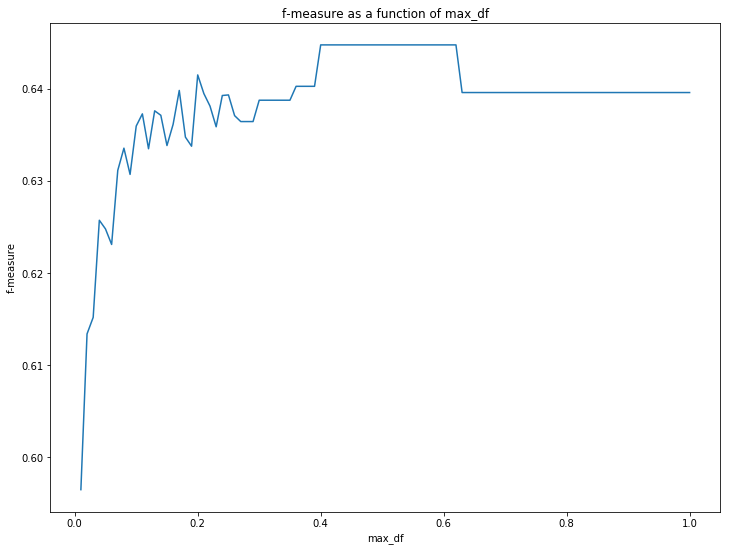

In [32]:
xs = [float(i)/100 for i in range(1,101)]
ys = [value for value,details in f_measures]
plt.plot(xs,ys)
plt.xlabel('max_df')
plt.ylabel('f-measure')
plt.title('f-measure as a function of max_df')
plt.show()

__results for full clean (all parameters =True)__

In [33]:
x_train, y_train, x_test , y_test = readMultilabelDataset()
clean_training  = cleanDatasetExtended(x_train, is_remove_numbers=True,is_lemmatization=True, is_remove_domain_words=True, is_remove_punctuation=True,is_stemming=True) 

clean_test =  cleanDatasetExtended(x_test,is_remove_numbers=True,is_lemmatization=True, is_remove_domain_words=True, is_remove_punctuation=True,is_stemming=True)



exact_accuracies , precisions , recalls , f_measures = optimize_max_df(clean_training,clean_test,y_train,y_test)  

sorted_accuracies = sorted(exact_accuracies, key=lambda x: x[0])[-1:]
sorted_precisions = sorted(precisions, key=lambda x: x[0])[-1:]
sorted_recalls = sorted(recalls, key=lambda x: x[0])[-1:]
sorted_f_measures = sorted(f_measures, key=lambda x: x[0])[-1:]

print('-'*8 + 'best subset accuracy: '+'-'*8)
for value,details in sorted_accuracies:
    print(details)   

print('-'*8 + 'best precision: '+'-'*8)
for value,details in sorted_precisions:
    print(details)  

print('-'*8 + 'best recall: '+'-'*8)
for value,details in sorted_recalls:
    print(details)   

print('-'*8 + 'best f-measure: '+'-'*8)
for value,details in sorted_f_measures:
    print(details) #todo

Cleaning & storing datasets completed in 0.0520000457764 seconds
number of models 100
--------Started constructing model number 1--------
--------Started constructing model number 2--------
--------Started constructing model number 3--------
--------Started constructing model number 4--------
--------Started constructing model number 5--------
--------Started constructing model number 6--------
--------Started constructing model number 7--------
--------Started constructing model number 8--------
--------Started constructing model number 9--------
--------Started constructing model number 10--------
--------Started constructing model number 11--------
--------Started constructing model number 12--------
--------Started constructing model number 13--------
--------Started constructing model number 14--------
--------Started constructing model number 15--------
--------Started constructing model number 16--------
--------Started constructing model number 17--------
--------Started constr

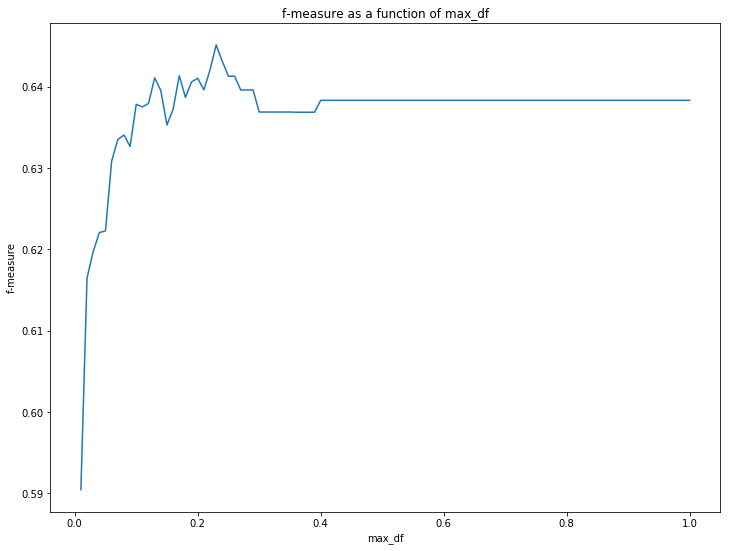

In [34]:
xs = [float(i)/100 for i in range(1,101)]
ys = [value for value,details in f_measures]
plt.plot(xs,ys)
plt.xlabel('max_df')
plt.ylabel('f-measure')
plt.title('f-measure as a function of max_df')
plt.show()

We can see that the both cleaning parameters have reached an optimal max_df that brought them to approximately same metrics over the test set.

As can be seen by the plot, max_df=(0.4~0.65) is optimal for the semi-cleaned dataset, and max_df=0.23 is optimal for the fully cleaned dataset.



And one more interesting statistic:

In [35]:
def f_measure_for_all_classes():
    x_train, y_train, x_test , y_test = readMultilabelDataset()
    x_clean_tr = cleanDatasetExtended(x_train,is_remove_numbers=True, is_remove_punctuation=True, is_lemmatization=True, is_stemming=True,is_remove_domain_words=True) 
    x_clean_te = cleanDatasetExtended(x_test,is_remove_numbers=True, is_remove_punctuation=True, is_lemmatization=True, is_stemming=True,is_remove_domain_words=True) 

    y_train = MultiLabelBinarizer().fit_transform(y_train)
    y_test = MultiLabelBinarizer().fit_transform(y_test)

    t0 = time()
    print("Extracting features for training set data...")
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.23,stop_words='english',ngram_range=(1,3))
    v_x_train = vectorizer.fit_transform(x_clean_tr)

    duration = time() - t0
    print("Finished feature extraction in " + str(duration)[:5] + ' seconds')
    samples , features = v_x_train.shape
    print("Number of samples: " + str(samples))
    print("Number of features: " + str(features))

    print("Extracting features for test set data...")
    t0 = time()
    v_x_test = vectorizer.transform(x_clean_te)
    duration = time() - t0
    print("Finished feature extraction in " + str(duration)[:5] + ' seconds')
    samples , features = v_x_test.shape
    print("Number of samples: " + str(samples))
    print("Number of features: " + str(features))


    clf = OneVsRestClassifier(Perceptron(alpha=0.0001,max_iter=8))

    t0 = time()
    clf.fit(v_x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(v_x_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    
    for i in range(23):
         print('f-measure for category number '+str(i+1)+': '+str(metrics.f1_score(y_test, pred, labels=[i],average='macro')))

f_measure_for_all_classes()

Extracting features for training set data...
Finished feature extraction in 7.675 seconds
Number of samples: 10433
Number of features: 943087
Extracting features for test set data...
Finished feature extraction in 3.788 seconds
Number of samples: 12733
Number of features: 943087
train time: 2.145s
test time:  0.146s
f-measure for category number 1: 0.602484067444
f-measure for category number 2: 0.469214437367
f-measure for category number 3: 0.651006711409
f-measure for category number 4: 0.791039551978
f-measure for category number 5: 0.616197183099
f-measure for category number 6: 0.679205110007
f-measure for category number 7: 0.557993730408
f-measure for category number 8: 0.623987659082
f-measure for category number 9: 0.544444444444
f-measure for category number 10: 0.591324200913
f-measure for category number 11: 0.638569604087
f-measure for category number 12: 0.753610503282
f-measure for category number 13: 0.661117717004
f-measure for category number 14: 0.754449924941
f-mea

It seems that generally categories with a lot of documents (categories 4,14 in particular) get better scores than categories with fewer documents (categories 2, 22 in particular).

##### Challenges and Conclusions

The most challenging parts were:

1. At first i was not aware that the dataset was multilabled, so i was quite surprised with the relatively weak results 
   i got using standard multiclass classifiers - the first challenge was figuring this out.

2. With some of the classifiers, cleaner data produced better metrics, while with others some of the cleaning steps were actually hindering the model's effectiveness.
    
3. Execution time for many promising classifiers (MLP, SVM, AdaBoost) was extremely long, made it very difficult to test

4. Sometimes, a model with less features would perform much better than one with more features, which could be counter-intuitive under the right light

5. As i stated before, the dataset is quite unbalanced which would naturally weaken models trained on it.

6. There were plenty of words which were very common across all categories, those had to be cut out; either with playing with the max_df parameter in TdfifVectorizer, or in the cleaning stage.

7. In the end, the difference in performance between my best model trained on clean data versus my best model trained on raw data was very small (about 0.1% in favor of the clean data), however cleaning did reduce the number of features by about 200,000.



### Notes


1. I did not play with the split between training and test datasets, that would be a "weak" way to get better results. 

2. The majority of the time that i spent on the assignment went towards finding the best model, with a lot of trial and error.

3. The best f-measure i was able to achieve was 0.645 (perceptron with alpha=0.0001, max_iter=8 and a 1-3 grams, max_df=0.23 vectorizer and fully clean data - see optimizePipeline2.txt). I checked some academic papers about classification on OHSUMED, and this result seemed in-line with their findings:

 page 74-77:

 https://www.researchgate.net/publication/220195924_A_hidden_Markov_model-based_text_classification_of_medical_documents

 page 15:

 https://peerj.com/articles/1279.pdf



